In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import torch # not used

In [2]:
import matplotlib
# matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


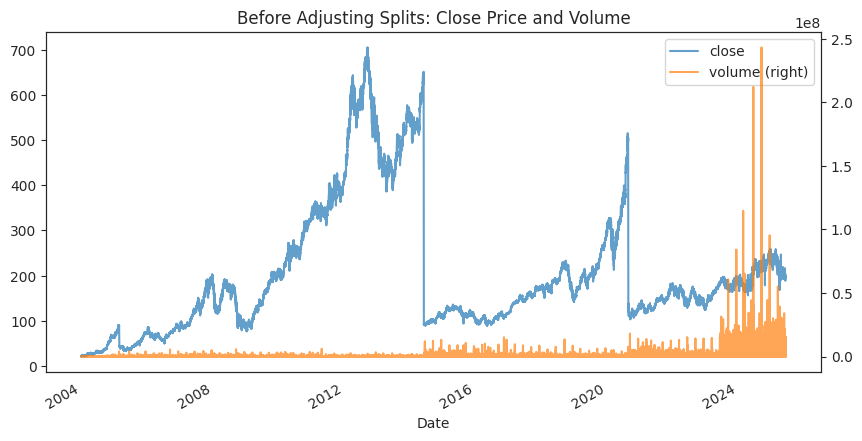

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


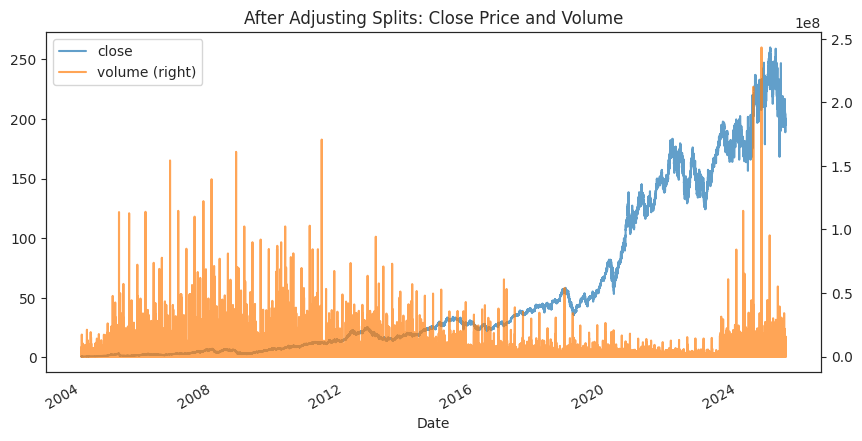

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penal_decay,
    trailing_stop_pct,
    buy_threshold,
    top_percentile
    # smoothing_window
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',
        min_prof_thr             = min_prof_thr,
        max_down_prop            = max_down_prop,
        gain_tightening_factor   = gain_tightening_factor,
        merging_retracement_thr  = merging_retracement_thr,
        merging_time_gap_thr     = merging_time_gap_thr,
        pre_entry_decay          = pre_entry_decay,
        short_penal_decay        = short_penal_decay,
        trailing_stop_pct        = trailing_stop_pct,
        buy_threshold            = buy_threshold,
        top_percentile           = top_percentile
        # smoothing_window         = smoothing_window
    )

    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.03, 0.3),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.03, 0.3),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.5, 5),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.01, 0.2),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.3, 3),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.02, 0.2),
        "short_penal_decay"       : trial.suggest_float("short_penal_decay", 0.5, 5),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.1), 
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.1, 0.9),
        "top_percentile"          : trial.suggest_float("top_percentile", 1, 20)
        # "smoothing_window"        : trial.suggest_categorical("smoothing_window", [1 ,2 ,3])
    }

    print('----------------------------------------------------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-08-21 13:56:01,971] A new study created in RDB with name: no-name-9cc73400-e47a-40bb-8dd2-43d2c6bd5412


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:01:26,996] Trial 0 finished with value: 0.3789829629629629 and parameters: {'min_prof_thr': 0.18296832990120276, 'max_down_prop': 0.20275653386515816, 'gain_tightening_factor': 4.00086106825531, 'merging_retracement_thr': 0.15382953746252762, 'merging_time_gap_thr': 0.9154966721090132, 'pre_entry_decay': 0.10111156332612797, 'short_penal_decay': 3.7702331570120697, 'trailing_stop_pct': 0.08169520825179818, 'buy_threshold': 0.774650150556786, 'top_percentile': 1.1135275408321617}. Best is trial 0 with value: 0.3789829629629629.


→ Total return across 5400 trading days: $2046.51
→ Avg daily return (all days)          : $0.3790
→ Total trades                          : 10522
→ Avg return per trade                  : $0.1945



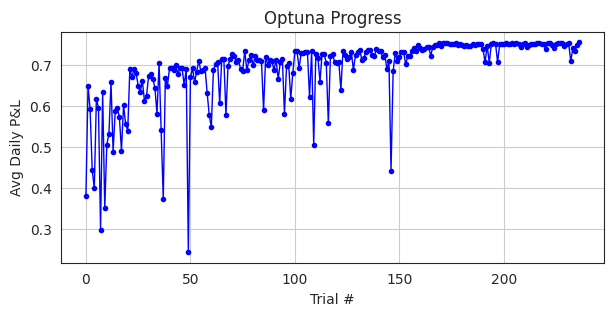

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:06:56,907] Trial 1 finished with value: 0.6480555555555556 and parameters: {'min_prof_thr': 0.2216873752895966, 'max_down_prop': 0.11695664601851886, 'gain_tightening_factor': 0.7142890627126837, 'merging_retracement_thr': 0.14463914466471442, 'merging_time_gap_thr': 2.1737123604737527, 'pre_entry_decay': 0.11802785656291988, 'short_penal_decay': 4.835475318637893, 'trailing_stop_pct': 0.04493401917872127, 'buy_threshold': 0.4568128707732443, 'top_percentile': 2.881005204964973}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $3499.50
→ Avg daily return (all days)          : $0.6481
→ Total trades                          : 32623
→ Avg return per trade                  : $0.1073

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:12:52,762] Trial 2 finished with value: 0.5915698148148147 and parameters: {'min_prof_thr': 0.09158904037403579, 'max_down_prop': 0.2453036633069706, 'gain_tightening_factor': 4.322301404968833, 'merging_retracement_thr': 0.13150463850433006, 'merging_time_gap_thr': 1.1949609969284098, 'pre_entry_decay': 0.170863296371092, 'short_penal_decay': 3.52305708071638, 'trailing_stop_pct': 0.08129727213202284, 'buy_threshold': 0.7547659695740827, 'top_percentile': 5.011116554100244}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $3194.48
→ Avg daily return (all days)          : $0.5916
→ Total trades                          : 42953
→ Avg return per trade                  : $0.0744

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:18:41,324] Trial 3 finished with value: 0.4427353703703704 and parameters: {'min_prof_thr': 0.14338538166694664, 'max_down_prop': 0.26742296403234767, 'gain_tightening_factor': 3.6523489867276546, 'merging_retracement_thr': 0.08120235763915686, 'merging_time_gap_thr': 2.00535726632894, 'pre_entry_decay': 0.1910504854277632, 'short_penal_decay': 4.19418346346466, 'trailing_stop_pct': 0.09597170174458144, 'buy_threshold': 0.16907956545413097, 'top_percentile': 8.37742303589522}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $2390.77
→ Avg daily return (all days)          : $0.4427
→ Total trades                          : 51733
→ Avg return per trade                  : $0.0462

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:22:37,211] Trial 4 finished with value: 0.3982672222222222 and parameters: {'min_prof_thr': 0.28544786377362064, 'max_down_prop': 0.2959802396527649, 'gain_tightening_factor': 4.63610316800211, 'merging_retracement_thr': 0.05843571365451889, 'merging_time_gap_thr': 1.0953216490029778, 'pre_entry_decay': 0.03168995908973511, 'short_penal_decay': 3.7227031802547694, 'trailing_stop_pct': 0.06469599702446999, 'buy_threshold': 0.21770571273948952, 'top_percentile': 16.774358067302888}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $2150.64
→ Avg daily return (all days)          : $0.3983
→ Total trades                          : 19619
→ Avg return per trade                  : $0.1096

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:26:10,802] Trial 5 finished with value: 0.6166331481481482 and parameters: {'min_prof_thr': 0.1188422952021522, 'max_down_prop': 0.12309524064466988, 'gain_tightening_factor': 0.8510040792191478, 'merging_retracement_thr': 0.0815800995416636, 'merging_time_gap_thr': 2.1963492449781303, 'pre_entry_decay': 0.06550978082073441, 'short_penal_decay': 3.37879624220149, 'trailing_stop_pct': 0.04660725543044582, 'buy_threshold': 0.2112142247677687, 'top_percentile': 2.454330883170848}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $3329.82
→ Avg daily return (all days)          : $0.6166
→ Total trades                          : 55195
→ Avg return per trade                  : $0.0603

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:29:27,067] Trial 6 finished with value: 0.5955703703703704 and parameters: {'min_prof_thr': 0.06486440685187915, 'max_down_prop': 0.2945207032081053, 'gain_tightening_factor': 1.7646966599137823, 'merging_retracement_thr': 0.19050269900942743, 'merging_time_gap_thr': 2.7402448190619255, 'pre_entry_decay': 0.14361116594068876, 'short_penal_decay': 4.663741228686351, 'trailing_stop_pct': 0.07662497942631606, 'buy_threshold': 0.6538835885803327, 'top_percentile': 6.027037857596334}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $3216.08
→ Avg daily return (all days)          : $0.5956
→ Total trades                          : 46853
→ Avg return per trade                  : $0.0686

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:33:06,584] Trial 7 finished with value: 0.2971251851851852 and parameters: {'min_prof_thr': 0.06986778932168479, 'max_down_prop': 0.22729295670585273, 'gain_tightening_factor': 4.629013552218848, 'merging_retracement_thr': 0.10817478607086016, 'merging_time_gap_thr': 1.6588493988252582, 'pre_entry_decay': 0.193957274962633, 'short_penal_decay': 4.567664778984815, 'trailing_stop_pct': 0.04240927407094058, 'buy_threshold': 0.16943776702454166, 'top_percentile': 8.591272511103515}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $1604.48
→ Avg daily return (all days)          : $0.2971
→ Total trades                          : 87479
→ Avg return per trade                  : $0.0183

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:38:15,604] Trial 8 finished with value: 0.6346785185185185 and parameters: {'min_prof_thr': 0.14044365486580437, 'max_down_prop': 0.1538156732393557, 'gain_tightening_factor': 4.602289282508622, 'merging_retracement_thr': 0.05800900560392623, 'merging_time_gap_thr': 2.9492216950036445, 'pre_entry_decay': 0.02649714913424405, 'short_penal_decay': 4.288418160424394, 'trailing_stop_pct': 0.06854994341218011, 'buy_threshold': 0.8199964915204556, 'top_percentile': 12.622860932288285}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $3427.26
→ Avg daily return (all days)          : $0.6347
→ Total trades                          : 25157
→ Avg return per trade                  : $0.1362

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:44:14,180] Trial 9 finished with value: 0.3497140740740741 and parameters: {'min_prof_thr': 0.047100053367184126, 'max_down_prop': 0.1364368691591545, 'gain_tightening_factor': 2.218221674321747, 'merging_retracement_thr': 0.06990534031193343, 'merging_time_gap_thr': 1.3056927745592786, 'pre_entry_decay': 0.1577923957886094, 'short_penal_decay': 4.1461377474076855, 'trailing_stop_pct': 0.041366567665253914, 'buy_threshold': 0.2554639202304097, 'top_percentile': 9.101657225060295}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $1888.46
→ Avg daily return (all days)          : $0.3497
→ Total trades                          : 87971
→ Avg return per trade                  : $0.0215

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:49:49,751] Trial 10 finished with value: 0.505391851851852 and parameters: {'min_prof_thr': 0.21916264357051418, 'max_down_prop': 0.04788531024819272, 'gain_tightening_factor': 0.5673602215179212, 'merging_retracement_thr': 0.015298308719283768, 'merging_time_gap_thr': 0.540618737610516, 'pre_entry_decay': 0.11543355033077106, 'short_penal_decay': 1.7289219635156936, 'trailing_stop_pct': 0.03191640810767107, 'buy_threshold': 0.4522165887102022, 'top_percentile': 19.616827912099566}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $2729.12
→ Avg daily return (all days)          : $0.5054
→ Total trades                          : 32023
→ Avg return per trade                  : $0.0852

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:55:25,214] Trial 11 finished with value: 0.5316938888888888 and parameters: {'min_prof_thr': 0.22279681694906409, 'max_down_prop': 0.08085963733941712, 'gain_tightening_factor': 2.9117951871446768, 'merging_retracement_thr': 0.02237489088937261, 'merging_time_gap_thr': 2.965846335294952, 'pre_entry_decay': 0.021638715013210942, 'short_penal_decay': 2.3753759375438697, 'trailing_stop_pct': 0.055770345475394, 'buy_threshold': 0.4885153854401658, 'top_percentile': 13.494783923104219}. Best is trial 1 with value: 0.6480555555555556.


→ Total return across 5400 trading days: $2871.15
→ Avg daily return (all days)          : $0.5317
→ Total trades                          : 28689
→ Avg return per trade                  : $0.1001

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 14:59:03,944] Trial 12 finished with value: 0.6576548148148148 and parameters: {'min_prof_thr': 0.18836667117965133, 'max_down_prop': 0.17221785440498255, 'gain_tightening_factor': 3.1867722048680385, 'merging_retracement_thr': 0.16674350773411062, 'merging_time_gap_thr': 2.4642071206567935, 'pre_entry_decay': 0.0823024682293467, 'short_penal_decay': 4.990958339872852, 'trailing_stop_pct': 0.06242785455377814, 'buy_threshold': 0.885327504449581, 'top_percentile': 12.26720802510861}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $3551.34
→ Avg daily return (all days)          : $0.6577
→ Total trades                          : 34405
→ Avg return per trade                  : $0.1032

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:01:48,969] Trial 13 finished with value: 0.48729240740740737 and parameters: {'min_prof_thr': 0.26577646897830826, 'max_down_prop': 0.1828256227286329, 'gain_tightening_factor': 3.0225342013165624, 'merging_retracement_thr': 0.17815435375372812, 'merging_time_gap_thr': 2.462931328861581, 'pre_entry_decay': 0.09550470479572157, 'short_penal_decay': 0.544106085392936, 'trailing_stop_pct': 0.05701032144773818, 'buy_threshold': 0.6188675312136714, 'top_percentile': 13.577692243765911}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $2631.38
→ Avg daily return (all days)          : $0.4873
→ Total trades                          : 26677
→ Avg return per trade                  : $0.0986

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:04:33,906] Trial 14 finished with value: 0.5861966666666667 and parameters: {'min_prof_thr': 0.1932405486930452, 'max_down_prop': 0.09402640121775357, 'gain_tightening_factor': 1.3587806400283298, 'merging_retracement_thr': 0.1530415011791577, 'merging_time_gap_thr': 1.9360580544660964, 'pre_entry_decay': 0.06581380042165055, 'short_penal_decay': 4.829076669452097, 'trailing_stop_pct': 0.03062223384644741, 'buy_threshold': 0.35422979674753285, 'top_percentile': 11.315639282975868}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $3165.46
→ Avg daily return (all days)          : $0.5862
→ Total trades                          : 36310
→ Avg return per trade                  : $0.0872

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:07:15,699] Trial 15 finished with value: 0.5950844444444444 and parameters: {'min_prof_thr': 0.24586811291907584, 'max_down_prop': 0.10794151207708128, 'gain_tightening_factor': 2.232348847278223, 'merging_retracement_thr': 0.15557480234361, 'merging_time_gap_thr': 2.3564299297868296, 'pre_entry_decay': 0.12367039569355562, 'short_penal_decay': 2.860254012161596, 'trailing_stop_pct': 0.05114932342603839, 'buy_threshold': 0.8965355462430211, 'top_percentile': 5.14006461195512}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $3213.46
→ Avg daily return (all days)          : $0.5951
→ Total trades                          : 29026
→ Avg return per trade                  : $0.1107

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:09:57,781] Trial 16 finished with value: 0.5725477777777779 and parameters: {'min_prof_thr': 0.19599741354511918, 'max_down_prop': 0.17561197457166636, 'gain_tightening_factor': 3.375602855763744, 'merging_retracement_thr': 0.13858274128545525, 'merging_time_gap_thr': 2.5539503993668333, 'pre_entry_decay': 0.07561402360234107, 'short_penal_decay': 1.5415829198481599, 'trailing_stop_pct': 0.06476729263423206, 'buy_threshold': 0.6101788380733476, 'top_percentile': 15.936095389420927}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $3091.76
→ Avg daily return (all days)          : $0.5725
→ Total trades                          : 39470
→ Avg return per trade                  : $0.0783

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:12:41,027] Trial 17 finished with value: 0.4904329629629629 and parameters: {'min_prof_thr': 0.23404081186695966, 'max_down_prop': 0.058360830992330956, 'gain_tightening_factor': 2.349964723661083, 'merging_retracement_thr': 0.11160957237602738, 'merging_time_gap_thr': 1.7092340010800744, 'pre_entry_decay': 0.13718876838001814, 'short_penal_decay': 4.958310733434855, 'trailing_stop_pct': 0.03805257786585533, 'buy_threshold': 0.37942550970407635, 'top_percentile': 15.422805835319593}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $2648.34
→ Avg daily return (all days)          : $0.4904
→ Total trades                          : 29136
→ Avg return per trade                  : $0.0909

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:15:25,916] Trial 18 finished with value: 0.6023807407407407 and parameters: {'min_prof_thr': 0.16631443283495376, 'max_down_prop': 0.14769621997748522, 'gain_tightening_factor': 1.2599171319236029, 'merging_retracement_thr': 0.1777192850445622, 'merging_time_gap_thr': 2.0732428481483947, 'pre_entry_decay': 0.0830365998369349, 'short_penal_decay': 2.6846128118947297, 'trailing_stop_pct': 0.09875695688585498, 'buy_threshold': 0.5818597535649563, 'top_percentile': 7.041670782899457}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $3252.86
→ Avg daily return (all days)          : $0.6024
→ Total trades                          : 42957
→ Avg return per trade                  : $0.0757

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:19:18,388] Trial 19 finished with value: 0.5543605555555555 and parameters: {'min_prof_thr': 0.28241164022880244, 'max_down_prop': 0.2024153129960253, 'gain_tightening_factor': 3.687576590265603, 'merging_retracement_thr': 0.19972644000985995, 'merging_time_gap_thr': 2.6653740514045845, 'pre_entry_decay': 0.04653281238689467, 'short_penal_decay': 4.942494174674252, 'trailing_stop_pct': 0.05732095782486278, 'buy_threshold': 0.33415245728077025, 'top_percentile': 3.5372980635207387}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $2993.55
→ Avg daily return (all days)          : $0.5544
→ Total trades                          : 21511
→ Avg return per trade                  : $0.1392

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:22:28,350] Trial 20 finished with value: 0.5394525925925926 and parameters: {'min_prof_thr': 0.25715927345482037, 'max_down_prop': 0.07157302675744025, 'gain_tightening_factor': 2.5992457044202992, 'merging_retracement_thr': 0.1309386060582973, 'merging_time_gap_thr': 1.4800632266667293, 'pre_entry_decay': 0.13013318227211332, 'short_penal_decay': 3.2651198258617464, 'trailing_stop_pct': 0.07051596557575784, 'buy_threshold': 0.7018635239029296, 'top_percentile': 10.61352565391037}. Best is trial 12 with value: 0.6576548148148148.


→ Total return across 5400 trading days: $2913.04
→ Avg daily return (all days)          : $0.5395
→ Total trades                          : 28528
→ Avg return per trade                  : $0.1021

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:25:46,790] Trial 21 finished with value: 0.6887007407407408 and parameters: {'min_prof_thr': 0.13565705510866496, 'max_down_prop': 0.14685501891326558, 'gain_tightening_factor': 4.95753619592666, 'merging_retracement_thr': 0.04249679238432574, 'merging_time_gap_thr': 2.969425863858315, 'pre_entry_decay': 0.04874479811827699, 'short_penal_decay': 4.200538154997748, 'trailing_stop_pct': 0.07195932951997788, 'buy_threshold': 0.8626961220082567, 'top_percentile': 12.393627789317321}. Best is trial 21 with value: 0.6887007407407408.


→ Total return across 5400 trading days: $3718.98
→ Avg daily return (all days)          : $0.6887
→ Total trades                          : 31917
→ Avg return per trade                  : $0.1165

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:28:35,327] Trial 22 finished with value: 0.6702144444444443 and parameters: {'min_prof_thr': 0.11737609190930694, 'max_down_prop': 0.11876539492934993, 'gain_tightening_factor': 1.7715645604786854, 'merging_retracement_thr': 0.16690514642758567, 'merging_time_gap_thr': 2.3058457416498204, 'pre_entry_decay': 0.04943968760944643, 'short_penal_decay': 4.334208374743213, 'trailing_stop_pct': 0.08516612613971242, 'buy_threshold': 0.8760360401450349, 'top_percentile': 11.825698760976069}. Best is trial 21 with value: 0.6887007407407408.


→ Total return across 5400 trading days: $3619.16
→ Avg daily return (all days)          : $0.6702
→ Total trades                          : 28672
→ Avg return per trade                  : $0.1262

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:31:21,008] Trial 23 finished with value: 0.6895533333333334 and parameters: {'min_prof_thr': 0.11630817383914899, 'max_down_prop': 0.17481100944278818, 'gain_tightening_factor': 1.6215454796972066, 'merging_retracement_thr': 0.03418504084052029, 'merging_time_gap_thr': 2.7689857477266897, 'pre_entry_decay': 0.048678844386341846, 'short_penal_decay': 4.004969140629141, 'trailing_stop_pct': 0.08767359772705385, 'buy_threshold': 0.8767049258839996, 'top_percentile': 12.027724058992675}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3723.59
→ Avg daily return (all days)          : $0.6896
→ Total trades                          : 31697
→ Avg return per trade                  : $0.1175

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:34:16,239] Trial 24 finished with value: 0.6801977777777777 and parameters: {'min_prof_thr': 0.10414203104293733, 'max_down_prop': 0.2009790379420325, 'gain_tightening_factor': 1.7365775831777546, 'merging_retracement_thr': 0.03438772081210499, 'merging_time_gap_thr': 2.726968074730151, 'pre_entry_decay': 0.04601098908324874, 'short_penal_decay': 3.957953704380968, 'trailing_stop_pct': 0.09202583726258842, 'buy_threshold': 0.8182067898908952, 'top_percentile': 14.510216075295903}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3673.07
→ Avg daily return (all days)          : $0.6802
→ Total trades                          : 35699
→ Avg return per trade                  : $0.1029

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:37:02,478] Trial 25 finished with value: 0.6488266666666667 and parameters: {'min_prof_thr': 0.10041523317953094, 'max_down_prop': 0.20264148888997757, 'gain_tightening_factor': 1.702699019473215, 'merging_retracement_thr': 0.036701859970820316, 'merging_time_gap_thr': 2.7949803051013964, 'pre_entry_decay': 0.04587049568985869, 'short_penal_decay': 3.7793410183070013, 'trailing_stop_pct': 0.09141067612168226, 'buy_threshold': 0.8078149505088159, 'top_percentile': 18.010710025389237}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3503.66
→ Avg daily return (all days)          : $0.6488
→ Total trades                          : 39629
→ Avg return per trade                  : $0.0884

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:39:48,173] Trial 26 finished with value: 0.6334051851851852 and parameters: {'min_prof_thr': 0.14672203217804555, 'max_down_prop': 0.23003218638142992, 'gain_tightening_factor': 1.2906542681871005, 'merging_retracement_thr': 0.03849156128033634, 'merging_time_gap_thr': 2.9917228266401983, 'pre_entry_decay': 0.05581304279496099, 'short_penal_decay': 3.000755704504561, 'trailing_stop_pct': 0.08918150780031507, 'buy_threshold': 0.7093090969914733, 'top_percentile': 14.604513798330437}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3420.39
→ Avg daily return (all days)          : $0.6334
→ Total trades                          : 44177
→ Avg return per trade                  : $0.0774

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:42:41,592] Trial 27 finished with value: 0.6611164814814815 and parameters: {'min_prof_thr': 0.031137431406306204, 'max_down_prop': 0.19308074942132988, 'gain_tightening_factor': 4.952575328737885, 'merging_retracement_thr': 0.03483619616001643, 'merging_time_gap_thr': 2.7233702389234766, 'pre_entry_decay': 0.03634236478932824, 'short_penal_decay': 4.043600461338595, 'trailing_stop_pct': 0.07637710314714335, 'buy_threshold': 0.8333535216241225, 'top_percentile': 9.716185832450476}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3570.03
→ Avg daily return (all days)          : $0.6611
→ Total trades                          : 27023
→ Avg return per trade                  : $0.1321

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:46:34,733] Trial 28 finished with value: 0.6121022222222222 and parameters: {'min_prof_thr': 0.09244006088378952, 'max_down_prop': 0.1588282999657708, 'gain_tightening_factor': 2.64156826765351, 'merging_retracement_thr': 0.010202069390847179, 'merging_time_gap_thr': 1.8380020742721592, 'pre_entry_decay': 0.06336003398337231, 'short_penal_decay': 3.89619437979114, 'trailing_stop_pct': 0.09437832704406823, 'buy_threshold': 0.7401331852710282, 'top_percentile': 17.41259944916217}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3305.35
→ Avg daily return (all days)          : $0.6121
→ Total trades                          : 46131
→ Avg return per trade                  : $0.0717

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:49:30,436] Trial 29 finished with value: 0.6249707407407408 and parameters: {'min_prof_thr': 0.12448247561608293, 'max_down_prop': 0.2220095292555433, 'gain_tightening_factor': 1.0633757550960603, 'merging_retracement_thr': 0.05085400633614284, 'merging_time_gap_thr': 0.33014158273009864, 'pre_entry_decay': 0.09908539289788225, 'short_penal_decay': 4.4986384810112705, 'trailing_stop_pct': 0.0846866281263949, 'buy_threshold': 0.7777081884954736, 'top_percentile': 14.476680785600484}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3374.84
→ Avg daily return (all days)          : $0.6250
→ Total trades                          : 50759
→ Avg return per trade                  : $0.0665

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:52:18,740] Trial 30 finished with value: 0.6722983333333333 and parameters: {'min_prof_thr': 0.1686178760817698, 'max_down_prop': 0.14075236465492735, 'gain_tightening_factor': 1.9795346079066076, 'merging_retracement_thr': 0.08805737447438698, 'merging_time_gap_thr': 2.6037842071726978, 'pre_entry_decay': 0.03940811570612254, 'short_penal_decay': 3.104882100682159, 'trailing_stop_pct': 0.07656123609967835, 'buy_threshold': 0.840594673980076, 'top_percentile': 10.356587373555143}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3630.41
→ Avg daily return (all days)          : $0.6723
→ Total trades                          : 27980
→ Avg return per trade                  : $0.1298

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:55:05,464] Trial 31 finished with value: 0.6783324074074074 and parameters: {'min_prof_thr': 0.16953355459053987, 'max_down_prop': 0.14344306383076139, 'gain_tightening_factor': 1.6104990749075445, 'merging_retracement_thr': 0.08426926935192997, 'merging_time_gap_thr': 2.614090210237418, 'pre_entry_decay': 0.0382450103463354, 'short_penal_decay': 2.406436279308747, 'trailing_stop_pct': 0.07875034832027164, 'buy_threshold': 0.8498335474644932, 'top_percentile': 10.396155546531881}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3662.99
→ Avg daily return (all days)          : $0.6783
→ Total trades                          : 29064
→ Avg return per trade                  : $0.1260

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 15:57:56,346] Trial 32 finished with value: 0.6665953703703703 and parameters: {'min_prof_thr': 0.1550655379057184, 'max_down_prop': 0.16694240411728883, 'gain_tightening_factor': 1.6023625484933437, 'merging_retracement_thr': 0.026677333929046667, 'merging_time_gap_thr': 2.799924388962626, 'pre_entry_decay': 0.05762976016872488, 'short_penal_decay': 2.1861856296452458, 'trailing_stop_pct': 0.08163390787757738, 'buy_threshold': 0.7864130248102924, 'top_percentile': 13.715167987927796}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3599.61
→ Avg daily return (all days)          : $0.6666
→ Total trades                          : 44698
→ Avg return per trade                  : $0.0805

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:00:44,614] Trial 33 finished with value: 0.644027962962963 and parameters: {'min_prof_thr': 0.10636090538950506, 'max_down_prop': 0.19085441185025342, 'gain_tightening_factor': 2.0000582311335844, 'merging_retracement_thr': 0.04631413637363993, 'merging_time_gap_thr': 2.848819909081482, 'pre_entry_decay': 0.07399509927798625, 'short_penal_decay': 3.5589306071421154, 'trailing_stop_pct': 0.0884732221559757, 'buy_threshold': 0.6851389542406454, 'top_percentile': 12.76573866075892}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3477.75
→ Avg daily return (all days)          : $0.6440
→ Total trades                          : 47678
→ Avg return per trade                  : $0.0729

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:03:32,554] Trial 34 finished with value: 0.5808274074074076 and parameters: {'min_prof_thr': 0.1333578490388768, 'max_down_prop': 0.21630491414074265, 'gain_tightening_factor': 0.8648971048380503, 'merging_retracement_thr': 0.07059039056036506, 'merging_time_gap_thr': 2.298682648289683, 'pre_entry_decay': 0.020770169060704308, 'short_penal_decay': 2.480340205791636, 'trailing_stop_pct': 0.07154444841267414, 'buy_threshold': 0.8561367614304602, 'top_percentile': 7.445359342822119}. Best is trial 23 with value: 0.6895533333333334.


→ Total return across 5400 trading days: $3136.47
→ Avg daily return (all days)          : $0.5808
→ Total trades                          : 18691
→ Avg return per trade                  : $0.1678

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:06:37,056] Trial 35 finished with value: 0.7038133333333333 and parameters: {'min_prof_thr': 0.07867624625065066, 'max_down_prop': 0.24812293906407834, 'gain_tightening_factor': 1.1253915731996238, 'merging_retracement_thr': 0.09212193415889997, 'merging_time_gap_thr': 2.546142312540562, 'pre_entry_decay': 0.037763451270885526, 'short_penal_decay': 2.052375380990537, 'trailing_stop_pct': 0.07889909679847686, 'buy_threshold': 0.7302901878075932, 'top_percentile': 10.986845693443803}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3800.59
→ Avg daily return (all days)          : $0.7038
→ Total trades                          : 37102
→ Avg return per trade                  : $0.1024

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:09:55,560] Trial 36 finished with value: 0.541034074074074 and parameters: {'min_prof_thr': 0.06934019770338969, 'max_down_prop': 0.2490763086949048, 'gain_tightening_factor': 4.130149917620787, 'merging_retracement_thr': 0.06781250702566247, 'merging_time_gap_thr': 2.4627924269163195, 'pre_entry_decay': 0.09076904333147057, 'short_penal_decay': 1.7300284623272657, 'trailing_stop_pct': 0.08557713900807351, 'buy_threshold': 0.7380250673772357, 'top_percentile': 15.703375181423791}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $2921.58
→ Avg daily return (all days)          : $0.5410
→ Total trades                          : 63474
→ Avg return per trade                  : $0.0460

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:13:03,055] Trial 37 finished with value: 0.37251240740740743 and parameters: {'min_prof_thr': 0.08144701376465247, 'max_down_prop': 0.2588754381905832, 'gain_tightening_factor': 1.048324550829709, 'merging_retracement_thr': 0.09377609808763074, 'merging_time_gap_thr': 2.10437054353719, 'pre_entry_decay': 0.10861540841185442, 'short_penal_decay': 1.012523419775619, 'trailing_stop_pct': 0.09328996302629593, 'buy_threshold': 0.5599670915064445, 'top_percentile': 10.96407571258515}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $2011.57
→ Avg daily return (all days)          : $0.3725
→ Total trades                          : 71109
→ Avg return per trade                  : $0.0283

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:16:02,872] Trial 38 finished with value: 0.6689068518518518 and parameters: {'min_prof_thr': 0.11041802345077271, 'max_down_prop': 0.26949893916899426, 'gain_tightening_factor': 0.5106646672284075, 'merging_retracement_thr': 0.025637022322463704, 'merging_time_gap_thr': 2.883219773898195, 'pre_entry_decay': 0.032743636585985406, 'short_penal_decay': 3.53865306191739, 'trailing_stop_pct': 0.0982712499149935, 'buy_threshold': 0.7671480759827307, 'top_percentile': 9.456304901475425}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3612.10
→ Avg daily return (all days)          : $0.6689
→ Total trades                          : 26183
→ Avg return per trade                  : $0.1380

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:19:46,584] Trial 39 finished with value: 0.6492557407407407 and parameters: {'min_prof_thr': 0.08395072462971181, 'max_down_prop': 0.24561032616131467, 'gain_tightening_factor': 1.9829317444198924, 'merging_retracement_thr': 0.0476640933752399, 'merging_time_gap_thr': 0.8034460459843894, 'pre_entry_decay': 0.05384212768171331, 'short_penal_decay': 2.0035350928871765, 'trailing_stop_pct': 0.0735624116800755, 'buy_threshold': 0.65809126294135, 'top_percentile': 12.775112851524849}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3505.98
→ Avg daily return (all days)          : $0.6493
→ Total trades                          : 51021
→ Avg return per trade                  : $0.0687

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:22:49,749] Trial 40 finished with value: 0.6914683333333334 and parameters: {'min_prof_thr': 0.05789611537065702, 'max_down_prop': 0.22012456345953835, 'gain_tightening_factor': 1.494114618981864, 'merging_retracement_thr': 0.1221616866911324, 'merging_time_gap_thr': 2.2241146640944685, 'pre_entry_decay': 0.07134914628986577, 'short_penal_decay': 3.9264751318895725, 'trailing_stop_pct': 0.07989614249123993, 'buy_threshold': 0.801402567078225, 'top_percentile': 11.675651356988721}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3733.93
→ Avg daily return (all days)          : $0.6915
→ Total trades                          : 41470
→ Avg return per trade                  : $0.0900

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:25:59,561] Trial 41 finished with value: 0.6929657407407407 and parameters: {'min_prof_thr': 0.05201875447854323, 'max_down_prop': 0.27984637237341925, 'gain_tightening_factor': 1.4047965499466224, 'merging_retracement_thr': 0.1122686194895258, 'merging_time_gap_thr': 2.7132677912276275, 'pre_entry_decay': 0.06938536841077347, 'short_penal_decay': 3.9836144358879535, 'trailing_stop_pct': 0.0803248659185332, 'buy_threshold': 0.8014877921282004, 'top_percentile': 11.488941835183539}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3742.01
→ Avg daily return (all days)          : $0.6930
→ Total trades                          : 40369
→ Avg return per trade                  : $0.0927

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:29:00,199] Trial 42 finished with value: 0.6879866666666667 and parameters: {'min_prof_thr': 0.05315625102446752, 'max_down_prop': 0.27920195210351895, 'gain_tightening_factor': 0.803013491323878, 'merging_retracement_thr': 0.1188424850958024, 'merging_time_gap_thr': 2.507167526644472, 'pre_entry_decay': 0.06989979171027494, 'short_penal_decay': 4.279492332027178, 'trailing_stop_pct': 0.07832187037170867, 'buy_threshold': 0.7467472352916668, 'top_percentile': 8.022073134840646}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3715.13
→ Avg daily return (all days)          : $0.6880
→ Total trades                          : 35043
→ Avg return per trade                  : $0.1060

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:31:55,458] Trial 43 finished with value: 0.6989557407407407 and parameters: {'min_prof_thr': 0.03349990888617335, 'max_down_prop': 0.2362630846004604, 'gain_tightening_factor': 1.431477276109269, 'merging_retracement_thr': 0.09535505520311652, 'merging_time_gap_thr': 2.2149479291856493, 'pre_entry_decay': 0.06118712511675178, 'short_penal_decay': 4.5043611226768485, 'trailing_stop_pct': 0.06786181892905772, 'buy_threshold': 0.8988306433526132, 'top_percentile': 11.594923209509226}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3774.36
→ Avg daily return (all days)          : $0.6990
→ Total trades                          : 34542
→ Avg return per trade                  : $0.1093

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:34:53,328] Trial 44 finished with value: 0.6768520370370371 and parameters: {'min_prof_thr': 0.030210217327759217, 'max_down_prop': 0.23668996168488093, 'gain_tightening_factor': 1.455916922733468, 'merging_retracement_thr': 0.09898548787021838, 'merging_time_gap_thr': 2.2400369426413893, 'pre_entry_decay': 0.08436163766104478, 'short_penal_decay': 4.629687370169577, 'trailing_stop_pct': 0.08214658893483452, 'buy_threshold': 0.7944643928770516, 'top_percentile': 11.570034666219819}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3655.00
→ Avg daily return (all days)          : $0.6769
→ Total trades                          : 42587
→ Avg return per trade                  : $0.0858

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:38:08,881] Trial 45 finished with value: 0.6926496296296296 and parameters: {'min_prof_thr': 0.05119386689063507, 'max_down_prop': 0.2817007985087523, 'gain_tightening_factor': 1.062942313162658, 'merging_retracement_thr': 0.12460929872894765, 'merging_time_gap_thr': 1.8906807367482288, 'pre_entry_decay': 0.06189505600569317, 'short_penal_decay': 3.6601910794185977, 'trailing_stop_pct': 0.06784241731808548, 'buy_threshold': 0.8985847349642084, 'top_percentile': 8.633391904340598}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3740.31
→ Avg daily return (all days)          : $0.6926
→ Total trades                          : 30503
→ Avg return per trade                  : $0.1226

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:41:04,583] Trial 46 finished with value: 0.6917003703703705 and parameters: {'min_prof_thr': 0.04704130839714411, 'max_down_prop': 0.28502373963986183, 'gain_tightening_factor': 0.9670428732680458, 'merging_retracement_thr': 0.1224903721830671, 'merging_time_gap_thr': 1.9127062175125078, 'pre_entry_decay': 0.06189495790041217, 'short_penal_decay': 3.783513717335252, 'trailing_stop_pct': 0.06807998025361452, 'buy_threshold': 0.8936438823459711, 'top_percentile': 8.73496542801664}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3735.18
→ Avg daily return (all days)          : $0.6917
→ Total trades                          : 30623
→ Avg return per trade                  : $0.1220

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:44:08,500] Trial 47 finished with value: 0.6515605555555556 and parameters: {'min_prof_thr': 0.042245862368646976, 'max_down_prop': 0.2877046464728633, 'gain_tightening_factor': 1.0705076625488141, 'merging_retracement_thr': 0.1019211032932945, 'merging_time_gap_thr': 1.902650015293626, 'pre_entry_decay': 0.06087686502497265, 'short_penal_decay': 3.3943440440986308, 'trailing_stop_pct': 0.06763891645766183, 'buy_threshold': 0.8934564388592757, 'top_percentile': 6.2636010853467265}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3518.43
→ Avg daily return (all days)          : $0.6516
→ Total trades                          : 25014
→ Avg return per trade                  : $0.1407

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:47:06,068] Trial 48 finished with value: 0.6895296296296296 and parameters: {'min_prof_thr': 0.0470022671698931, 'max_down_prop': 0.2963280825318512, 'gain_tightening_factor': 0.6324922137191304, 'merging_retracement_thr': 0.11410823704766664, 'merging_time_gap_thr': 1.7274623788972847, 'pre_entry_decay': 0.08997475101518701, 'short_penal_decay': 3.704132401802269, 'trailing_stop_pct': 0.06143750056677448, 'buy_threshold': 0.8430205222171673, 'top_percentile': 8.745153252397127}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3723.46
→ Avg daily return (all days)          : $0.6895
→ Total trades                          : 39366
→ Avg return per trade                  : $0.0946

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:49:54,633] Trial 49 finished with value: 0.24214796296296298 and parameters: {'min_prof_thr': 0.07569623108082194, 'max_down_prop': 0.2746396522611948, 'gain_tightening_factor': 0.9199523738093678, 'merging_retracement_thr': 0.13496553418587592, 'merging_time_gap_thr': 2.0104318973627073, 'pre_entry_decay': 0.18008926829337135, 'short_penal_decay': 3.246620804578498, 'trailing_stop_pct': 0.06811095896298441, 'buy_threshold': 0.11546160753409596, 'top_percentile': 7.917232358671218}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $1307.60
→ Avg daily return (all days)          : $0.2421
→ Total trades                          : 70454
→ Avg return per trade                  : $0.0186

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:52:38,268] Trial 50 finished with value: 0.6693581481481481 and parameters: {'min_prof_thr': 0.06094511785522816, 'max_down_prop': 0.25775695889812994, 'gain_tightening_factor': 1.157011321965269, 'merging_retracement_thr': 0.12626488655567372, 'merging_time_gap_thr': 1.4682851848048255, 'pre_entry_decay': 0.030862593289128014, 'short_penal_decay': 4.411316010004162, 'trailing_stop_pct': 0.06259578103854305, 'buy_threshold': 0.7265711785503727, 'top_percentile': 9.727621366842953}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3614.53
→ Avg daily return (all days)          : $0.6694
→ Total trades                          : 28383
→ Avg return per trade                  : $0.1273

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:55:20,701] Trial 51 finished with value: 0.6915901851851851 and parameters: {'min_prof_thr': 0.05640477460210948, 'max_down_prop': 0.2832312874696993, 'gain_tightening_factor': 1.4183015049746912, 'merging_retracement_thr': 0.14358913757023745, 'merging_time_gap_thr': 2.168453594368077, 'pre_entry_decay': 0.07582830880186324, 'short_penal_decay': 3.711608827237968, 'trailing_stop_pct': 0.07422954351906733, 'buy_threshold': 0.8983577383214104, 'top_percentile': 8.975246423313804}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3734.59
→ Avg daily return (all days)          : $0.6916
→ Total trades                          : 34247
→ Avg return per trade                  : $0.1090

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 16:58:03,730] Trial 52 finished with value: 0.6579155555555555 and parameters: {'min_prof_thr': 0.039589783770031646, 'max_down_prop': 0.2856621426775055, 'gain_tightening_factor': 1.3165694220185105, 'merging_retracement_thr': 0.14396036553749905, 'merging_time_gap_thr': 2.1478223975476176, 'pre_entry_decay': 0.07988734382068083, 'short_penal_decay': 3.7574488290707757, 'trailing_stop_pct': 0.07510564651476195, 'buy_threshold': 0.894402595462739, 'top_percentile': 6.913609262950098}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3552.74
→ Avg daily return (all days)          : $0.6579
→ Total trades                          : 29588
→ Avg return per trade                  : $0.1201

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:00:44,944] Trial 53 finished with value: 0.68375 and parameters: {'min_prof_thr': 0.06388238517341205, 'max_down_prop': 0.26164831779671205, 'gain_tightening_factor': 0.9298876131219249, 'merging_retracement_thr': 0.11002952265260815, 'merging_time_gap_thr': 2.3929360257850796, 'pre_entry_decay': 0.06591420770476752, 'short_penal_decay': 4.779718503103034, 'trailing_stop_pct': 0.06597512081216171, 'buy_threshold': 0.8975569954639996, 'top_percentile': 8.91856281540953}. Best is trial 35 with value: 0.7038133333333333.


→ Total return across 5400 trading days: $3692.25
→ Avg daily return (all days)          : $0.6837
→ Total trades                          : 29798
→ Avg return per trade                  : $0.1239

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:03:27,167] Trial 54 finished with value: 0.7103424074074074 and parameters: {'min_prof_thr': 0.052469942514558665, 'max_down_prop': 0.28145261306384534, 'gain_tightening_factor': 0.7331287605737884, 'merging_retracement_thr': 0.1491393925538897, 'merging_time_gap_thr': 1.5549096079108513, 'pre_entry_decay': 0.07633524609243818, 'short_penal_decay': 4.140370160627498, 'trailing_stop_pct': 0.05930953677328896, 'buy_threshold': 0.8211215103192641, 'top_percentile': 9.89398702655954}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3835.85
→ Avg daily return (all days)          : $0.7103
→ Total trades                          : 39044
→ Avg return per trade                  : $0.0982

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:06:11,626] Trial 55 finished with value: 0.6840529629629629 and parameters: {'min_prof_thr': 0.03919783642724024, 'max_down_prop': 0.2936487965837425, 'gain_tightening_factor': 0.7494599735376601, 'merging_retracement_thr': 0.09466186768572109, 'merging_time_gap_thr': 1.523391621712961, 'pre_entry_decay': 0.10798900793467706, 'short_penal_decay': 4.162195712251074, 'trailing_stop_pct': 0.053063927957458054, 'buy_threshold': 0.8177672182815255, 'top_percentile': 10.250040693675544}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3693.89
→ Avg daily return (all days)          : $0.6841
→ Total trades                          : 47446
→ Avg return per trade                  : $0.0779

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:08:52,691] Trial 56 finished with value: 0.687813888888889 and parameters: {'min_prof_thr': 0.07337069204475458, 'max_down_prop': 0.29974362267377586, 'gain_tightening_factor': 0.7102907758934505, 'merging_retracement_thr': 0.15146711792623777, 'merging_time_gap_thr': 1.1411434340601359, 'pre_entry_decay': 0.05690019287265512, 'short_penal_decay': 1.1974041476443613, 'trailing_stop_pct': 0.059810382086610825, 'buy_threshold': 0.7732963262958055, 'top_percentile': 5.735415414867725}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3714.20
→ Avg daily return (all days)          : $0.6878
→ Total trades                          : 33151
→ Avg return per trade                  : $0.1120

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:11:35,254] Trial 57 finished with value: 0.6924937037037039 and parameters: {'min_prof_thr': 0.09129809231735656, 'max_down_prop': 0.26832048730993974, 'gain_tightening_factor': 1.1623509190383434, 'merging_retracement_thr': 0.0749125637871123, 'merging_time_gap_thr': 1.8107489919499846, 'pre_entry_decay': 0.041405411213122745, 'short_penal_decay': 4.691637533041761, 'trailing_stop_pct': 0.05375481741087849, 'buy_threshold': 0.8551256284169905, 'top_percentile': 10.817612468919888}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3739.47
→ Avg daily return (all days)          : $0.6925
→ Total trades                          : 29401
→ Avg return per trade                  : $0.1272

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:14:17,210] Trial 58 finished with value: 0.6319453703703704 and parameters: {'min_prof_thr': 0.09054322970577139, 'max_down_prop': 0.25181388281735406, 'gain_tightening_factor': 1.1856135786959436, 'merging_retracement_thr': 0.06687445808509493, 'merging_time_gap_thr': 1.5729657753829678, 'pre_entry_decay': 0.025686418152243033, 'short_penal_decay': 4.657500253479757, 'trailing_stop_pct': 0.05148345153997878, 'buy_threshold': 0.8457314943016184, 'top_percentile': 11.04509068113996}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3412.51
→ Avg daily return (all days)          : $0.6319
→ Total trades                          : 24730
→ Avg return per trade                  : $0.1380

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:16:58,036] Trial 59 finished with value: 0.5780264814814815 and parameters: {'min_prof_thr': 0.09380491463355756, 'max_down_prop': 0.26897973562326555, 'gain_tightening_factor': 1.8788089207737926, 'merging_retracement_thr': 0.07305993726734632, 'merging_time_gap_thr': 1.7845046330923555, 'pre_entry_decay': 0.08950096620053075, 'short_penal_decay': 4.454360907238806, 'trailing_stop_pct': 0.0482986125146135, 'buy_threshold': 0.5260835666508514, 'top_percentile': 1.0738080874619875}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3121.34
→ Avg daily return (all days)          : $0.5780
→ Total trades                          : 20489
→ Avg return per trade                  : $0.1523

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:19:40,998] Trial 60 finished with value: 0.5483807407407406 and parameters: {'min_prof_thr': 0.08048095867827518, 'max_down_prop': 0.2386377646326759, 'gain_tightening_factor': 0.516593923509006, 'merging_retracement_thr': 0.07766047339298213, 'merging_time_gap_thr': 1.3641812094494394, 'pre_entry_decay': 0.15324454219321557, 'short_penal_decay': 4.815531365884935, 'trailing_stop_pct': 0.054655921078192414, 'buy_threshold': 0.6617417255057596, 'top_percentile': 13.498661962450713}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $2961.26
→ Avg daily return (all days)          : $0.5484
→ Total trades                          : 67706
→ Avg return per trade                  : $0.0437

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:22:23,691] Trial 61 finished with value: 0.6875979629629628 and parameters: {'min_prof_thr': 0.06713955872902372, 'max_down_prop': 0.27595119653929717, 'gain_tightening_factor': 1.0405533378365508, 'merging_retracement_thr': 0.10516524166893326, 'merging_time_gap_thr': 1.9588705490329836, 'pre_entry_decay': 0.041837428439923746, 'short_penal_decay': 4.353089775851213, 'trailing_stop_pct': 0.05958869009718656, 'buy_threshold': 0.861002879396247, 'top_percentile': 9.929474154341463}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3713.03
→ Avg daily return (all days)          : $0.6876
→ Total trades                          : 27957
→ Avg return per trade                  : $0.1328

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:25:07,288] Trial 62 finished with value: 0.7025437037037037 and parameters: {'min_prof_thr': 0.05012437457091212, 'max_down_prop': 0.2643099472782707, 'gain_tightening_factor': 1.2395921577358535, 'merging_retracement_thr': 0.11668131717138847, 'merging_time_gap_thr': 1.621145104505485, 'pre_entry_decay': 0.06556014219074355, 'short_penal_decay': 4.103181406441683, 'trailing_stop_pct': 0.06965772559723193, 'buy_threshold': 0.803727006372098, 'top_percentile': 8.309539745828943}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3793.74
→ Avg daily return (all days)          : $0.7025
→ Total trades                          : 33541
→ Avg return per trade                  : $0.1131

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:27:51,140] Trial 63 finished with value: 0.7078637037037037 and parameters: {'min_prof_thr': 0.05364581752869787, 'max_down_prop': 0.2648508978016982, 'gain_tightening_factor': 1.2122357273482864, 'merging_retracement_thr': 0.08922285239747021, 'merging_time_gap_thr': 1.6337024147901464, 'pre_entry_decay': 0.05299268319332253, 'short_penal_decay': 4.09774217332564, 'trailing_stop_pct': 0.06560736122318041, 'buy_threshold': 0.8287832434091554, 'top_percentile': 10.840631218633112}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3822.46
→ Avg daily return (all days)          : $0.7079
→ Total trades                          : 34481
→ Avg return per trade                  : $0.1109

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:30:34,077] Trial 64 finished with value: 0.6059 and parameters: {'min_prof_thr': 0.05119171878524506, 'max_down_prop': 0.2574620304696463, 'gain_tightening_factor': 1.3577185722999303, 'merging_retracement_thr': 0.08925776335155186, 'merging_time_gap_thr': 1.635806640163691, 'pre_entry_decay': 0.05343305195408078, 'short_penal_decay': 4.087281558472999, 'trailing_stop_pct': 0.06399696235047884, 'buy_threshold': 0.8174561006579949, 'top_percentile': 4.477960343809476}. Best is trial 54 with value: 0.7103424074074074.


→ Total return across 5400 trading days: $3271.86
→ Avg daily return (all days)          : $0.6059
→ Total trades                          : 20388
→ Avg return per trade                  : $0.1605

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:33:19,807] Trial 65 finished with value: 0.7141357407407407 and parameters: {'min_prof_thr': 0.036982036131615534, 'max_down_prop': 0.2365079783104326, 'gain_tightening_factor': 2.1902288869101088, 'merging_retracement_thr': 0.11580413308288738, 'merging_time_gap_thr': 1.2800118431741478, 'pre_entry_decay': 0.06757011983073803, 'short_penal_decay': 2.7506825500943677, 'trailing_stop_pct': 0.07094429406607185, 'buy_threshold': 0.7575208520265833, 'top_percentile': 7.837589426110558}. Best is trial 65 with value: 0.7141357407407407.


→ Total return across 5400 trading days: $3856.33
→ Avg daily return (all days)          : $0.7141
→ Total trades                          : 38841
→ Avg return per trade                  : $0.0993

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:36:04,939] Trial 66 finished with value: 0.7145161111111111 and parameters: {'min_prof_thr': 0.035413961386079724, 'max_down_prop': 0.2313560274259031, 'gain_tightening_factor': 2.432819457368832, 'merging_retracement_thr': 0.11550236678164438, 'merging_time_gap_thr': 0.9900203570988652, 'pre_entry_decay': 0.0676824219081194, 'short_penal_decay': 2.80577951652767, 'trailing_stop_pct': 0.07029685958833914, 'buy_threshold': 0.6994464832832032, 'top_percentile': 6.7209224453649465}. Best is trial 66 with value: 0.7145161111111111.


→ Total return across 5400 trading days: $3858.39
→ Avg daily return (all days)          : $0.7145
→ Total trades                          : 38736
→ Avg return per trade                  : $0.0996

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:38:48,847] Trial 67 finished with value: 0.5782925925925926 and parameters: {'min_prof_thr': 0.03335627859724899, 'max_down_prop': 0.2369581749533, 'gain_tightening_factor': 2.410564888838822, 'merging_retracement_thr': 0.09861457624353195, 'merging_time_gap_thr': 0.9408396996934375, 'pre_entry_decay': 0.07882359097830591, 'short_penal_decay': 2.7893030784085546, 'trailing_stop_pct': 0.06513246835783612, 'buy_threshold': 0.6923066390063027, 'top_percentile': 2.112667503901962}. Best is trial 66 with value: 0.7145161111111111.


→ Total return across 5400 trading days: $3122.78
→ Avg daily return (all days)          : $0.5783
→ Total trades                          : 21025
→ Avg return per trade                  : $0.1485

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:41:34,496] Trial 68 finished with value: 0.6982922222222221 and parameters: {'min_prof_thr': 0.03835298065093314, 'max_down_prop': 0.21483702612896816, 'gain_tightening_factor': 2.900905922032049, 'merging_retracement_thr': 0.16190999094882774, 'merging_time_gap_thr': 1.2728467250461346, 'pre_entry_decay': 0.051857143139226264, 'short_penal_decay': 2.606375274674163, 'trailing_stop_pct': 0.07034223016418918, 'buy_threshold': 0.7177079853725343, 'top_percentile': 6.440439922553107}. Best is trial 66 with value: 0.7145161111111111.


→ Total return across 5400 trading days: $3770.78
→ Avg daily return (all days)          : $0.6983
→ Total trades                          : 31889
→ Avg return per trade                  : $0.1182

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:44:18,440] Trial 69 finished with value: 0.7141361111111111 and parameters: {'min_prof_thr': 0.06196926247665942, 'max_down_prop': 0.22590141432758118, 'gain_tightening_factor': 2.276658158189206, 'merging_retracement_thr': 0.13229386456633, 'merging_time_gap_thr': 1.0294672075152196, 'pre_entry_decay': 0.06745764717553729, 'short_penal_decay': 2.135427405073213, 'trailing_stop_pct': 0.059192106382082874, 'buy_threshold': 0.6153878452685261, 'top_percentile': 7.4773012456861245}. Best is trial 66 with value: 0.7145161111111111.


→ Total return across 5400 trading days: $3856.34
→ Avg daily return (all days)          : $0.7141
→ Total trades                          : 49188
→ Avg return per trade                  : $0.0784

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:47:02,509] Trial 70 finished with value: 0.726728888888889 and parameters: {'min_prof_thr': 0.06146574033152842, 'max_down_prop': 0.20898473733105782, 'gain_tightening_factor': 2.4578825749664213, 'merging_retracement_thr': 0.13201740652648342, 'merging_time_gap_thr': 0.9538682072881933, 'pre_entry_decay': 0.06991879389477579, 'short_penal_decay': 1.8124370749996586, 'trailing_stop_pct': 0.05771758786470996, 'buy_threshold': 0.6202124419151568, 'top_percentile': 4.961669788205745}. Best is trial 70 with value: 0.726728888888889.


→ Total return across 5400 trading days: $3924.34
→ Avg daily return (all days)          : $0.7267
→ Total trades                          : 42107
→ Avg return per trade                  : $0.0932

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:49:45,268] Trial 71 finished with value: 0.7222824074074073 and parameters: {'min_prof_thr': 0.0629157251866791, 'max_down_prop': 0.21165444374462167, 'gain_tightening_factor': 2.263160911339858, 'merging_retracement_thr': 0.1311950980485949, 'merging_time_gap_thr': 0.9947269456452689, 'pre_entry_decay': 0.06671148882005437, 'short_penal_decay': 2.1549920029060328, 'trailing_stop_pct': 0.05647690405106741, 'buy_threshold': 0.6209953684887547, 'top_percentile': 4.651519650804699}. Best is trial 70 with value: 0.726728888888889.


→ Total return across 5400 trading days: $3900.32
→ Avg daily return (all days)          : $0.7223
→ Total trades                          : 38603
→ Avg return per trade                  : $0.1010

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:52:27,773] Trial 72 finished with value: 0.7059364814814815 and parameters: {'min_prof_thr': 0.06313404405238107, 'max_down_prop': 0.20925181525148284, 'gain_tightening_factor': 2.1866390620517695, 'merging_retracement_thr': 0.15270410509205454, 'merging_time_gap_thr': 1.0056938705585372, 'pre_entry_decay': 0.08263033283709632, 'short_penal_decay': 2.1510153374780336, 'trailing_stop_pct': 0.05769223994251105, 'buy_threshold': 0.6181321024790112, 'top_percentile': 3.910269945581792}. Best is trial 70 with value: 0.726728888888889.


→ Total return across 5400 trading days: $3812.06
→ Avg daily return (all days)          : $0.7059
→ Total trades                          : 38702
→ Avg return per trade                  : $0.0985

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:55:10,767] Trial 73 finished with value: 0.7107283333333333 and parameters: {'min_prof_thr': 0.06029476793661298, 'max_down_prop': 0.20767027091547718, 'gain_tightening_factor': 2.1485964654217797, 'merging_retracement_thr': 0.13746251161876993, 'merging_time_gap_thr': 0.9671978548780995, 'pre_entry_decay': 0.08556412544213579, 'short_penal_decay': 1.7410492146477523, 'trailing_stop_pct': 0.05755497314557952, 'buy_threshold': 0.6231087994259503, 'top_percentile': 3.86421108345405}. Best is trial 70 with value: 0.726728888888889.


→ Total return across 5400 trading days: $3837.93
→ Avg daily return (all days)          : $0.7107
→ Total trades                          : 40726
→ Avg return per trade                  : $0.0942

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 17:57:54,545] Trial 74 finished with value: 0.6898812962962962 and parameters: {'min_prof_thr': 0.07200294159537965, 'max_down_prop': 0.22768485661783497, 'gain_tightening_factor': 2.472126808842023, 'merging_retracement_thr': 0.132400976241338, 'merging_time_gap_thr': 0.7279649268723519, 'pre_entry_decay': 0.10005585763679402, 'short_penal_decay': 1.724782261158578, 'trailing_stop_pct': 0.06003292712570251, 'buy_threshold': 0.5868352391388956, 'top_percentile': 5.367141965208108}. Best is trial 70 with value: 0.726728888888889.


→ Total return across 5400 trading days: $3725.36
→ Avg daily return (all days)          : $0.6899
→ Total trades                          : 55205
→ Avg return per trade                  : $0.0675

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:00:38,792] Trial 75 finished with value: 0.6855205555555556 and parameters: {'min_prof_thr': 0.04338741849124628, 'max_down_prop': 0.18597741433340426, 'gain_tightening_factor': 2.169955489587456, 'merging_retracement_thr': 0.1367652323615389, 'merging_time_gap_thr': 1.0488980444188891, 'pre_entry_decay': 0.08648997147042628, 'short_penal_decay': 1.4435806669761782, 'trailing_stop_pct': 0.0568360306340625, 'buy_threshold': 0.6373878273644238, 'top_percentile': 3.0987283574774764}. Best is trial 70 with value: 0.726728888888889.


→ Total return across 5400 trading days: $3701.81
→ Avg daily return (all days)          : $0.6855
→ Total trades                          : 35993
→ Avg return per trade                  : $0.1028

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:03:22,739] Trial 76 finished with value: 0.7339762962962962 and parameters: {'min_prof_thr': 0.05944702077297394, 'max_down_prop': 0.20796855432257863, 'gain_tightening_factor': 2.746724534780455, 'merging_retracement_thr': 0.12850657080638303, 'merging_time_gap_thr': 0.7136083260808981, 'pre_entry_decay': 0.07338016368360446, 'short_penal_decay': 1.9055465390696105, 'trailing_stop_pct': 0.044439353944002113, 'buy_threshold': 0.5309022722031013, 'top_percentile': 4.625453665255833}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3963.47
→ Avg daily return (all days)          : $0.7340
→ Total trades                          : 49566
→ Avg return per trade                  : $0.0800

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:06:14,309] Trial 77 finished with value: 0.6866146296296296 and parameters: {'min_prof_thr': 0.06550043119522252, 'max_down_prop': 0.1974764145159033, 'gain_tightening_factor': 2.8167885566057698, 'merging_retracement_thr': 0.13056314813492967, 'merging_time_gap_thr': 0.7932826962195515, 'pre_entry_decay': 0.09545262260527938, 'short_penal_decay': 1.8910551207873585, 'trailing_stop_pct': 0.03778826038791558, 'buy_threshold': 0.44697726005967475, 'top_percentile': 4.575969557513941}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3707.72
→ Avg daily return (all days)          : $0.6866
→ Total trades                          : 64855
→ Avg return per trade                  : $0.0572

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:08:59,584] Trial 78 finished with value: 0.7119114814814815 and parameters: {'min_prof_thr': 0.20478731239026868, 'max_down_prop': 0.20808295844895244, 'gain_tightening_factor': 3.262267450245321, 'merging_retracement_thr': 0.14220920550258373, 'merging_time_gap_thr': 0.5839229060482826, 'pre_entry_decay': 0.07287496105577944, 'short_penal_decay': 1.4747973946680253, 'trailing_stop_pct': 0.045094464978070736, 'buy_threshold': 0.5266565777431622, 'top_percentile': 2.4535076618614013}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3844.32
→ Avg daily return (all days)          : $0.7119
→ Total trades                          : 37225
→ Avg return per trade                  : $0.1033

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:11:41,672] Trial 79 finished with value: 0.7230724074074074 and parameters: {'min_prof_thr': 0.18573314033396587, 'max_down_prop': 0.20994282028743794, 'gain_tightening_factor': 3.1309864704989754, 'merging_retracement_thr': 0.15967098710243469, 'merging_time_gap_thr': 0.6078550721187541, 'pre_entry_decay': 0.06849672982346115, 'short_penal_decay': 2.3237539638113374, 'trailing_stop_pct': 0.047188286859419636, 'buy_threshold': 0.5232826752810904, 'top_percentile': 3.7912731869606686}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3904.59
→ Avg daily return (all days)          : $0.7231
→ Total trades                          : 40281
→ Avg return per trade                  : $0.0969

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:14:23,334] Trial 80 finished with value: 0.69991 and parameters: {'min_prof_thr': 0.18257561827040156, 'max_down_prop': 0.21029415468546495, 'gain_tightening_factor': 3.1252760811732574, 'merging_retracement_thr': 0.15755973205126883, 'merging_time_gap_thr': 0.5219309060660596, 'pre_entry_decay': 0.06929194432357645, 'short_penal_decay': 2.227986032872346, 'trailing_stop_pct': 0.04397752748219564, 'buy_threshold': 0.4922649301608205, 'top_percentile': 2.0479251225359043}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3779.51
→ Avg daily return (all days)          : $0.6999
→ Total trades                          : 32912
→ Avg return per trade                  : $0.1148

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:17:05,370] Trial 81 finished with value: 0.7210164814814816 and parameters: {'min_prof_thr': 0.2035812863244964, 'max_down_prop': 0.22341403251849054, 'gain_tightening_factor': 3.381982822497543, 'merging_retracement_thr': 0.14235380345123247, 'merging_time_gap_thr': 0.6645961779109383, 'pre_entry_decay': 0.07300860041464824, 'short_penal_decay': 2.333341239080896, 'trailing_stop_pct': 0.047488745639521004, 'buy_threshold': 0.5154934859301755, 'top_percentile': 3.8611776822682353}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3893.49
→ Avg daily return (all days)          : $0.7210
→ Total trades                          : 41857
→ Avg return per trade                  : $0.0930

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:19:46,296] Trial 82 finished with value: 0.7114781481481482 and parameters: {'min_prof_thr': 0.21920316254600528, 'max_down_prop': 0.22447249158795307, 'gain_tightening_factor': 3.4606331034883495, 'merging_retracement_thr': 0.1777452170473331, 'merging_time_gap_thr': 0.5543699807095396, 'pre_entry_decay': 0.07298546870508796, 'short_penal_decay': 2.310582469621111, 'trailing_stop_pct': 0.03881103634991265, 'buy_threshold': 0.5235868219732893, 'top_percentile': 4.768665479848538}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3841.98
→ Avg daily return (all days)          : $0.7115
→ Total trades                          : 40332
→ Avg return per trade                  : $0.0953

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:22:27,637] Trial 83 finished with value: 0.711179814814815 and parameters: {'min_prof_thr': 0.20609177359405703, 'max_down_prop': 0.1847958620047666, 'gain_tightening_factor': 3.2963550613373482, 'merging_retracement_thr': 0.14091799803136865, 'merging_time_gap_thr': 0.6305003148720848, 'pre_entry_decay': 0.06721404471598794, 'short_penal_decay': 2.4985515093971364, 'trailing_stop_pct': 0.04642784332357432, 'buy_threshold': 0.4303306973200076, 'top_percentile': 2.926838354600388}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3840.37
→ Avg daily return (all days)          : $0.7112
→ Total trades                          : 39931
→ Avg return per trade                  : $0.0962

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:25:10,764] Trial 84 finished with value: 0.7087662962962963 and parameters: {'min_prof_thr': 0.20404753637456496, 'max_down_prop': 0.2310694158013741, 'gain_tightening_factor': 2.60388053917302, 'merging_retracement_thr': 0.12828152663071477, 'merging_time_gap_thr': 0.8870163431762879, 'pre_entry_decay': 0.07766370081166846, 'short_penal_decay': 1.9788778056577678, 'trailing_stop_pct': 0.049953353558717474, 'buy_threshold': 0.5563328537314083, 'top_percentile': 5.53567261072853}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3827.34
→ Avg daily return (all days)          : $0.7088
→ Total trades                          : 44608
→ Avg return per trade                  : $0.0858

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:27:52,370] Trial 85 finished with value: 0.5887187037037037 and parameters: {'min_prof_thr': 0.1790671744369378, 'max_down_prop': 0.19513500656800464, 'gain_tightening_factor': 3.0199776463701875, 'merging_retracement_thr': 0.17114198296809133, 'merging_time_gap_thr': 0.3930101761397303, 'pre_entry_decay': 0.05772019010613802, 'short_penal_decay': 2.9111297811853363, 'trailing_stop_pct': 0.04137726145736129, 'buy_threshold': 0.5806099995454519, 'top_percentile': 1.7627795247304499}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3179.08
→ Avg daily return (all days)          : $0.5887
→ Total trades                          : 20186
→ Avg return per trade                  : $0.1575

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:30:33,506] Trial 86 finished with value: 0.7201346296296298 and parameters: {'min_prof_thr': 0.20004831111702864, 'max_down_prop': 0.21692824297279314, 'gain_tightening_factor': 3.6472066263308323, 'merging_retracement_thr': 0.14811258458362597, 'merging_time_gap_thr': 0.6775278446153228, 'pre_entry_decay': 0.07525623696269153, 'short_penal_decay': 2.6306214718911596, 'trailing_stop_pct': 0.0434045467274936, 'buy_threshold': 0.5234869156857809, 'top_percentile': 4.073416709672487}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3888.73
→ Avg daily return (all days)          : $0.7201
→ Total trades                          : 41495
→ Avg return per trade                  : $0.0937

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:33:15,876] Trial 87 finished with value: 0.699965 and parameters: {'min_prof_thr': 0.23649653109739463, 'max_down_prop': 0.21419473087834537, 'gain_tightening_factor': 3.690323089083277, 'merging_retracement_thr': 0.11995653950692116, 'merging_time_gap_thr': 0.8690223214391464, 'pre_entry_decay': 0.09511746752243667, 'short_penal_decay': 2.56524711662735, 'trailing_stop_pct': 0.03638096446051951, 'buy_threshold': 0.5592830480394186, 'top_percentile': 3.323754492291954}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3779.81
→ Avg daily return (all days)          : $0.7000
→ Total trades                          : 36986
→ Avg return per trade                  : $0.1022

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:35:59,140] Trial 88 finished with value: 0.7130494444444445 and parameters: {'min_prof_thr': 0.19027720992079042, 'max_down_prop': 0.2203015332053289, 'gain_tightening_factor': 3.8800483684612534, 'merging_retracement_thr': 0.1476742103304054, 'merging_time_gap_thr': 0.7049880222456401, 'pre_entry_decay': 0.08055774194846708, 'short_penal_decay': 2.3469456743626456, 'trailing_stop_pct': 0.04805729131511438, 'buy_threshold': 0.4707435463922084, 'top_percentile': 4.035856432182673}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3850.47
→ Avg daily return (all days)          : $0.7130
→ Total trades                          : 46011
→ Avg return per trade                  : $0.0837

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:38:39,752] Trial 89 finished with value: 0.7083303703703704 and parameters: {'min_prof_thr': 0.17586024899980457, 'max_down_prop': 0.17917990774166753, 'gain_tightening_factor': 2.7556945930083834, 'merging_retracement_thr': 0.15838888783891872, 'merging_time_gap_thr': 1.1355742519924206, 'pre_entry_decay': 0.05994257972175451, 'short_penal_decay': 2.694814885656268, 'trailing_stop_pct': 0.04270190275616395, 'buy_threshold': 0.5976351450931787, 'top_percentile': 5.100166297867924}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3824.98
→ Avg daily return (all days)          : $0.7083
→ Total trades                          : 35832
→ Avg return per trade                  : $0.1067

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:41:22,891] Trial 90 finished with value: 0.6877364814814814 and parameters: {'min_prof_thr': 0.19665533664391818, 'max_down_prop': 0.24229970825387986, 'gain_tightening_factor': 2.3286609300229713, 'merging_retracement_thr': 0.18908975579712822, 'merging_time_gap_thr': 0.47681532682168704, 'pre_entry_decay': 0.06516997947348169, 'short_penal_decay': 1.8858740913475298, 'trailing_stop_pct': 0.03395116381289255, 'buy_threshold': 0.41359297549980256, 'top_percentile': 6.108250257831597}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3713.78
→ Avg daily return (all days)          : $0.6877
→ Total trades                          : 46315
→ Avg return per trade                  : $0.0802

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:44:05,556] Trial 91 finished with value: 0.7128203703703704 and parameters: {'min_prof_thr': 0.1901118122691092, 'max_down_prop': 0.22058369883583143, 'gain_tightening_factor': 3.576971800684495, 'merging_retracement_thr': 0.1638468919651428, 'merging_time_gap_thr': 0.7121485660605054, 'pre_entry_decay': 0.0720100916687511, 'short_penal_decay': 2.298337410381926, 'trailing_stop_pct': 0.04843300538808928, 'buy_threshold': 0.4777546686976005, 'top_percentile': 4.239404516807574}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3849.23
→ Avg daily return (all days)          : $0.7128
→ Total trades                          : 44744
→ Avg return per trade                  : $0.0860

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:46:45,923] Trial 92 finished with value: 0.6651114814814816 and parameters: {'min_prof_thr': 0.22817229447482926, 'max_down_prop': 0.22961127218226002, 'gain_tightening_factor': 3.9393929523503237, 'merging_retracement_thr': 0.1490936223351764, 'merging_time_gap_thr': 0.649790723097067, 'pre_entry_decay': 0.07941617092255672, 'short_penal_decay': 2.3822028488922653, 'trailing_stop_pct': 0.05192665972811126, 'buy_threshold': 0.5130828398040743, 'top_percentile': 6.783945582144914}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3591.60
→ Avg daily return (all days)          : $0.6651
→ Total trades                          : 38162
→ Avg return per trade                  : $0.0941

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:49:26,368] Trial 93 finished with value: 0.7065787037037037 and parameters: {'min_prof_thr': 0.21055750287779734, 'max_down_prop': 0.21906529891107113, 'gain_tightening_factor': 3.9318012102251365, 'merging_retracement_thr': 0.1473254180024466, 'merging_time_gap_thr': 0.7455334910651101, 'pre_entry_decay': 0.08168798538142011, 'short_penal_decay': 2.1091434551301815, 'trailing_stop_pct': 0.04975210386690958, 'buy_threshold': 0.4723658418542164, 'top_percentile': 3.6613278767193957}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3815.53
→ Avg daily return (all days)          : $0.7066
→ Total trades                          : 42318
→ Avg return per trade                  : $0.0902

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:52:08,248] Trial 94 finished with value: 0.7140244444444442 and parameters: {'min_prof_thr': 0.15835829587151776, 'max_down_prop': 0.20229369062627506, 'gain_tightening_factor': 2.517952216841905, 'merging_retracement_thr': 0.1347604809651224, 'merging_time_gap_thr': 0.827493003319642, 'pre_entry_decay': 0.10398460672184733, 'short_penal_decay': 2.901688969239172, 'trailing_stop_pct': 0.04689717956272456, 'buy_threshold': 0.5449315859849251, 'top_percentile': 4.2938375558024235}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3855.73
→ Avg daily return (all days)          : $0.7140
→ Total trades                          : 47733
→ Avg return per trade                  : $0.0808

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:54:47,891] Trial 95 finished with value: 0.5799862962962963 and parameters: {'min_prof_thr': 0.29282235481475594, 'max_down_prop': 0.1989419693915117, 'gain_tightening_factor': 2.507122564116814, 'merging_retracement_thr': 0.1331733856702505, 'merging_time_gap_thr': 1.0504852056579694, 'pre_entry_decay': 0.13576847431713038, 'short_penal_decay': 3.0715431713794077, 'trailing_stop_pct': 0.04599178831449333, 'buy_threshold': 0.6711135389485318, 'top_percentile': 7.644556898830928}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3131.93
→ Avg daily return (all days)          : $0.5800
→ Total trades                          : 27729
→ Avg return per trade                  : $0.1129

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 18:57:29,715] Trial 96 finished with value: 0.6974818518518519 and parameters: {'min_prof_thr': 0.2140023731277323, 'max_down_prop': 0.20341434155649393, 'gain_tightening_factor': 2.2917708013978912, 'merging_retracement_thr': 0.12854067894351756, 'merging_time_gap_thr': 0.82271154955885, 'pre_entry_decay': 0.11324167554251864, 'short_penal_decay': 2.9068294560832206, 'trailing_stop_pct': 0.043402641081391, 'buy_threshold': 0.5551340474126871, 'top_percentile': 5.837085555547905}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3766.40
→ Avg daily return (all days)          : $0.6975
→ Total trades                          : 43245
→ Avg return per trade                  : $0.0871

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:00:11,945] Trial 97 finished with value: 0.7034720370370371 and parameters: {'min_prof_thr': 0.15840558106552133, 'max_down_prop': 0.18827420997022648, 'gain_tightening_factor': 2.636801166346536, 'merging_retracement_thr': 0.13977225548756164, 'merging_time_gap_thr': 1.2279333279870412, 'pre_entry_decay': 0.12574270546018074, 'short_penal_decay': 2.802450190788225, 'trailing_stop_pct': 0.039887090414703126, 'buy_threshold': 0.6328295203901416, 'top_percentile': 4.938828498852226}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3798.75
→ Avg daily return (all days)          : $0.7035
→ Total trades                          : 48001
→ Avg return per trade                  : $0.0791

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:02:52,455] Trial 98 finished with value: 0.6169853703703703 and parameters: {'min_prof_thr': 0.27051876871397973, 'max_down_prop': 0.20388311910800397, 'gain_tightening_factor': 2.0627984240711363, 'merging_retracement_thr': 0.11691510780321904, 'merging_time_gap_thr': 0.44239347619599184, 'pre_entry_decay': 0.1055896173414698, 'short_penal_decay': 2.5011343579819734, 'trailing_stop_pct': 0.055011465714707566, 'buy_threshold': 0.5474580365536056, 'top_percentile': 7.409364817624284}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3331.72
→ Avg daily return (all days)          : $0.6170
→ Total trades                          : 30627
→ Avg return per trade                  : $0.1088

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:05:36,828] Trial 99 finished with value: 0.6801890740740741 and parameters: {'min_prof_thr': 0.19691471502382119, 'max_down_prop': 0.23146038504303748, 'gain_tightening_factor': 2.517937241375474, 'merging_retracement_thr': 0.10590775839865474, 'merging_time_gap_thr': 0.8463046733356201, 'pre_entry_decay': 0.0918246324345359, 'short_penal_decay': 2.6462372217983408, 'trailing_stop_pct': 0.07260662770991973, 'buy_threshold': 0.5072248495140103, 'top_percentile': 5.3211305696451845}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3673.02
→ Avg daily return (all days)          : $0.6802
→ Total trades                          : 44436
→ Avg return per trade                  : $0.0827

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:08:21,191] Trial 100 finished with value: 0.7334403703703702 and parameters: {'min_prof_thr': 0.17533789763261287, 'max_down_prop': 0.24293410805887883, 'gain_tightening_factor': 3.057986871613031, 'merging_retracement_thr': 0.12421394572129513, 'merging_time_gap_thr': 0.9323156137778426, 'pre_entry_decay': 0.07523371777509594, 'short_penal_decay': 1.6298529999457805, 'trailing_stop_pct': 0.04163311968745219, 'buy_threshold': 0.5389695492773496, 'top_percentile': 4.229417073167607}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3960.58
→ Avg daily return (all days)          : $0.7334
→ Total trades                          : 48017
→ Avg return per trade                  : $0.0825

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:11:06,870] Trial 101 finished with value: 0.7333264814814815 and parameters: {'min_prof_thr': 0.1455962301757545, 'max_down_prop': 0.25196691886174116, 'gain_tightening_factor': 3.1283796702429982, 'merging_retracement_thr': 0.12429800287903767, 'merging_time_gap_thr': 0.91373320107893, 'pre_entry_decay': 0.06804689696556229, 'short_penal_decay': 1.8564695542231417, 'trailing_stop_pct': 0.047111170276534636, 'buy_threshold': 0.5436710710522532, 'top_percentile': 3.3424176168802857}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3959.96
→ Avg daily return (all days)          : $0.7333
→ Total trades                          : 39944
→ Avg return per trade                  : $0.0991

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:13:52,335] Trial 102 finished with value: 0.6917949999999999 and parameters: {'min_prof_thr': 0.17122242840266666, 'max_down_prop': 0.2521772032196566, 'gain_tightening_factor': 3.064233939025406, 'merging_retracement_thr': 0.12626230100457494, 'merging_time_gap_thr': 0.9292339182858632, 'pre_entry_decay': 0.0683389286767437, 'short_penal_decay': 1.6165122179951803, 'trailing_stop_pct': 0.04084694584820137, 'buy_threshold': 0.6010209298298574, 'top_percentile': 2.6371726764359176}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3735.69
→ Avg daily return (all days)          : $0.6918
→ Total trades                          : 31851
→ Avg return per trade                  : $0.1173

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:16:38,023] Trial 103 finished with value: 0.7289064814814814 and parameters: {'min_prof_thr': 0.15038986034972157, 'max_down_prop': 0.2457498579941085, 'gain_tightening_factor': 2.8913983700561983, 'merging_retracement_thr': 0.1232199302791529, 'merging_time_gap_thr': 1.11756686257105, 'pre_entry_decay': 0.07568956466372889, 'short_penal_decay': 1.8750942934667356, 'trailing_stop_pct': 0.0451822150624642, 'buy_threshold': 0.5841956927330656, 'top_percentile': 3.545008129540511}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3936.09
→ Avg daily return (all days)          : $0.7289
→ Total trades                          : 39727
→ Avg return per trade                  : $0.0991

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:19:18,100] Trial 104 finished with value: 0.7280881481481482 and parameters: {'min_prof_thr': 0.14655171700403619, 'max_down_prop': 0.22570624078265344, 'gain_tightening_factor': 2.9344655570623424, 'merging_retracement_thr': 0.12296368583071879, 'merging_time_gap_thr': 0.9968096884228174, 'pre_entry_decay': 0.07581468645688323, 'short_penal_decay': 1.8712162219760788, 'trailing_stop_pct': 0.04419726199879334, 'buy_threshold': 0.5756917298998687, 'top_percentile': 3.407519266709304}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3931.68
→ Avg daily return (all days)          : $0.7281
→ Total trades                          : 39624
→ Avg return per trade                  : $0.0992

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:21:58,607] Trial 105 finished with value: 0.7323542592592593 and parameters: {'min_prof_thr': 0.1463015737303101, 'max_down_prop': 0.24386880232505448, 'gain_tightening_factor': 2.873982245780331, 'merging_retracement_thr': 0.12450682644292894, 'merging_time_gap_thr': 0.6404608298164103, 'pre_entry_decay': 0.07595271556977297, 'short_penal_decay': 1.3293609959521335, 'trailing_stop_pct': 0.044662980510662635, 'buy_threshold': 0.5777725080309345, 'top_percentile': 3.386749801909257}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3954.71
→ Avg daily return (all days)          : $0.7324
→ Total trades                          : 42055
→ Avg return per trade                  : $0.0940

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:24:41,254] Trial 106 finished with value: 0.7312525925925926 and parameters: {'min_prof_thr': 0.1438450206228088, 'max_down_prop': 0.24961394450061328, 'gain_tightening_factor': 2.939124673931621, 'merging_retracement_thr': 0.1207122102201669, 'merging_time_gap_thr': 0.6603719514117299, 'pre_entry_decay': 0.07541739237209029, 'short_penal_decay': 1.024621338054166, 'trailing_stop_pct': 0.0445160856762144, 'buy_threshold': 0.5362923208525415, 'top_percentile': 3.5677112740217742}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3948.76
→ Avg daily return (all days)          : $0.7313
→ Total trades                          : 48621
→ Avg return per trade                  : $0.0812

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:27:22,876] Trial 107 finished with value: 0.620692037037037 and parameters: {'min_prof_thr': 0.14298797408494768, 'max_down_prop': 0.2419274791897095, 'gain_tightening_factor': 2.9462982936562354, 'merging_retracement_thr': 0.12075983584207682, 'merging_time_gap_thr': 0.6074762804373818, 'pre_entry_decay': 0.08749317133436711, 'short_penal_decay': 1.2909334140432658, 'trailing_stop_pct': 0.045056339923405894, 'buy_threshold': 0.5728234070630395, 'top_percentile': 1.3786432608689556}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3351.74
→ Avg daily return (all days)          : $0.6207
→ Total trades                          : 26996
→ Avg return per trade                  : $0.1242

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:30:03,995] Trial 108 finished with value: 0.733052962962963 and parameters: {'min_prof_thr': 0.12893626421888152, 'max_down_prop': 0.25301496482578856, 'gain_tightening_factor': 3.1954472105843057, 'merging_retracement_thr': 0.10967411369854937, 'merging_time_gap_thr': 0.31217168235099374, 'pre_entry_decay': 0.06298562775071334, 'short_penal_decay': 1.0608712258188078, 'trailing_stop_pct': 0.04980270213410845, 'buy_threshold': 0.5369848176614302, 'top_percentile': 3.250448167817458}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3958.49
→ Avg daily return (all days)          : $0.7331
→ Total trades                          : 42298
→ Avg return per trade                  : $0.0936

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:32:48,533] Trial 109 finished with value: 0.5043605555555556 and parameters: {'min_prof_thr': 0.12792385748164098, 'max_down_prop': 0.2533551755859682, 'gain_tightening_factor': 2.808655002117264, 'merging_retracement_thr': 0.11022629220843547, 'merging_time_gap_thr': 1.0931122963671287, 'pre_entry_decay': 0.19935919018290893, 'short_penal_decay': 0.807117481808837, 'trailing_stop_pct': 0.0497720701060472, 'buy_threshold': 0.5382730018534537, 'top_percentile': 3.539298938024774}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $2723.55
→ Avg daily return (all days)          : $0.5044
→ Total trades                          : 75252
→ Avg return per trade                  : $0.0362

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:35:34,587] Trial 110 finished with value: 0.7253425925925927 and parameters: {'min_prof_thr': 0.14972342347017042, 'max_down_prop': 0.24464189438600836, 'gain_tightening_factor': 3.1618966726256867, 'merging_retracement_thr': 0.12408409552811042, 'merging_time_gap_thr': 0.3018370758172491, 'pre_entry_decay': 0.06399863816239135, 'short_penal_decay': 0.9388961458995466, 'trailing_stop_pct': 0.041707045278269995, 'buy_threshold': 0.5721563965365198, 'top_percentile': 3.1909361736793502}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3916.85
→ Avg daily return (all days)          : $0.7253
→ Total trades                          : 39986
→ Avg return per trade                  : $0.0980

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:38:26,389] Trial 111 finished with value: 0.7175983333333332 and parameters: {'min_prof_thr': 0.14868711653877686, 'max_down_prop': 0.24576954018122735, 'gain_tightening_factor': 3.2209303368758144, 'merging_retracement_thr': 0.12597375252954385, 'merging_time_gap_thr': 0.7746898012526594, 'pre_entry_decay': 0.05766146933676297, 'short_penal_decay': 0.903482418821761, 'trailing_stop_pct': 0.04138417897726256, 'buy_threshold': 0.5742115648001135, 'top_percentile': 3.209681897565571}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3875.03
→ Avg daily return (all days)          : $0.7176
→ Total trades                          : 37957
→ Avg return per trade                  : $0.1021

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:41:13,283] Trial 112 finished with value: 0.6590161111111111 and parameters: {'min_prof_thr': 0.16446676980308547, 'max_down_prop': 0.25780822597402725, 'gain_tightening_factor': 3.1578559683354053, 'merging_retracement_thr': 0.12374407367011482, 'merging_time_gap_thr': 0.39738890644936986, 'pre_entry_decay': 0.06300918836032042, 'short_penal_decay': 1.1854511634384286, 'trailing_stop_pct': 0.04458285711388486, 'buy_threshold': 0.643467304827915, 'top_percentile': 2.557987338624386}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3558.69
→ Avg daily return (all days)          : $0.6590
→ Total trades                          : 28317
→ Avg return per trade                  : $0.1257

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:44:00,965] Trial 113 finished with value: 0.7266407407407407 and parameters: {'min_prof_thr': 0.13604920265066126, 'max_down_prop': 0.24729358133905, 'gain_tightening_factor': 2.9191184533900136, 'merging_retracement_thr': 0.11946388490443091, 'merging_time_gap_thr': 0.3343880829678832, 'pre_entry_decay': 0.050007121456312253, 'short_penal_decay': 0.6368000046710398, 'trailing_stop_pct': 0.036540877757408205, 'buy_threshold': 0.49433776527256834, 'top_percentile': 2.8753720896909947}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3923.86
→ Avg daily return (all days)          : $0.7266
→ Total trades                          : 42431
→ Avg return per trade                  : $0.0925

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:47:17,538] Trial 114 finished with value: 0.7258137037037037 and parameters: {'min_prof_thr': 0.135965599235497, 'max_down_prop': 0.2432003999528697, 'gain_tightening_factor': 2.9079020472590846, 'merging_retracement_thr': 0.11379805056928911, 'merging_time_gap_thr': 0.32495992007927854, 'pre_entry_decay': 0.050275703125409014, 'short_penal_decay': 0.6986752728998071, 'trailing_stop_pct': 0.036228614978514505, 'buy_threshold': 0.4927609657560998, 'top_percentile': 2.738684340395028}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3919.39
→ Avg daily return (all days)          : $0.7258
→ Total trades                          : 41546
→ Avg return per trade                  : $0.0943

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:50:17,406] Trial 115 finished with value: 0.7051316666666666 and parameters: {'min_prof_thr': 0.13742071768240613, 'max_down_prop': 0.2491438578113662, 'gain_tightening_factor': 2.9142561592449696, 'merging_retracement_thr': 0.10902492553336998, 'merging_time_gap_thr': 0.30510622526430553, 'pre_entry_decay': 0.04840762765463567, 'short_penal_decay': 0.502769520333948, 'trailing_stop_pct': 0.03484508688531393, 'buy_threshold': 0.4923380708505734, 'top_percentile': 2.2059461105343035}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3807.71
→ Avg daily return (all days)          : $0.7051
→ Total trades                          : 37693
→ Avg return per trade                  : $0.1010

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:53:02,688] Trial 116 finished with value: 0.5569396296296296 and parameters: {'min_prof_thr': 0.12951075114516958, 'max_down_prop': 0.25560196966607646, 'gain_tightening_factor': 2.7009312274407877, 'merging_retracement_thr': 0.10204669084797471, 'merging_time_gap_thr': 0.36178302429870285, 'pre_entry_decay': 0.04414681411806809, 'short_penal_decay': 0.6378417800248679, 'trailing_stop_pct': 0.034164037647257825, 'buy_threshold': 0.5991333183117268, 'top_percentile': 1.5574331548643339}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3007.47
→ Avg daily return (all days)          : $0.5569
→ Total trades                          : 21048
→ Avg return per trade                  : $0.1429

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:55:56,408] Trial 117 finished with value: 0.7227437037037037 and parameters: {'min_prof_thr': 0.1491721603876313, 'max_down_prop': 0.24229186045328113, 'gain_tightening_factor': 2.97536664565348, 'merging_retracement_thr': 0.11296138518241555, 'merging_time_gap_thr': 0.480313314046768, 'pre_entry_decay': 0.054996063298476144, 'short_penal_decay': 1.0253591153922361, 'trailing_stop_pct': 0.03231966246716352, 'buy_threshold': 0.5698638867133748, 'top_percentile': 3.41134215771225}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3902.82
→ Avg daily return (all days)          : $0.7227
→ Total trades                          : 39104
→ Avg return per trade                  : $0.0998

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 19:58:41,493] Trial 118 finished with value: 0.7265929629629629 and parameters: {'min_prof_thr': 0.1517016851803766, 'max_down_prop': 0.2616468434744966, 'gain_tightening_factor': 2.8368848359003587, 'merging_retracement_thr': 0.12000985223031493, 'merging_time_gap_thr': 0.3517804829715514, 'pre_entry_decay': 0.04943028234116666, 'short_penal_decay': 0.752953862456585, 'trailing_stop_pct': 0.037186337608554415, 'buy_threshold': 0.4996733176088204, 'top_percentile': 2.8940458573590435}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3923.60
→ Avg daily return (all days)          : $0.7266
→ Total trades                          : 41158
→ Avg return per trade                  : $0.0953

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:01:28,682] Trial 119 finished with value: 0.7071577777777777 and parameters: {'min_prof_thr': 0.11942835385890216, 'max_down_prop': 0.26556067021370655, 'gain_tightening_factor': 2.876715713472898, 'merging_retracement_thr': 0.10708591536946199, 'merging_time_gap_thr': 0.42814641757734795, 'pre_entry_decay': 0.03451560861615368, 'short_penal_decay': 0.6707268760588843, 'trailing_stop_pct': 0.03687140264576087, 'buy_threshold': 0.4480705863719239, 'top_percentile': 2.808757589828502}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3818.65
→ Avg daily return (all days)          : $0.7072
→ Total trades                          : 39779
→ Avg return per trade                  : $0.0960

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:04:16,981] Trial 120 finished with value: 0.7046883333333332 and parameters: {'min_prof_thr': 0.13919553589085037, 'max_down_prop': 0.26193237873627445, 'gain_tightening_factor': 2.7175609306935034, 'merging_retracement_thr': 0.11917797788057684, 'merging_time_gap_thr': 0.5109108954327053, 'pre_entry_decay': 0.050342727450943585, 'short_penal_decay': 1.356800620409815, 'trailing_stop_pct': 0.039785005586094845, 'buy_threshold': 0.5041212489776657, 'top_percentile': 2.250313058036781}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3805.32
→ Avg daily return (all days)          : $0.7047
→ Total trades                          : 33705
→ Avg return per trade                  : $0.1129

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:07:02,411] Trial 121 finished with value: 0.7081161111111111 and parameters: {'min_prof_thr': 0.14971342553990846, 'max_down_prop': 0.24816640824331745, 'gain_tightening_factor': 3.3306662406704195, 'merging_retracement_thr': 0.1225991601592008, 'merging_time_gap_thr': 0.3504354508395459, 'pre_entry_decay': 0.04525833055197355, 'short_penal_decay': 1.0311341823160016, 'trailing_stop_pct': 0.03566420355276907, 'buy_threshold': 0.5330970463981439, 'top_percentile': 3.0198706217421623}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3823.83
→ Avg daily return (all days)          : $0.7081
→ Total trades                          : 36062
→ Avg return per trade                  : $0.1060

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:09:49,784] Trial 122 finished with value: 0.6389405555555556 and parameters: {'min_prof_thr': 0.16396934446931855, 'max_down_prop': 0.2344693788290881, 'gain_tightening_factor': 3.0576696473358664, 'merging_retracement_thr': 0.11305009710239368, 'merging_time_gap_thr': 0.31519515189041136, 'pre_entry_decay': 0.061200495309088145, 'short_penal_decay': 0.8321834150290647, 'trailing_stop_pct': 0.03897655644108157, 'buy_threshold': 0.5889983523200056, 'top_percentile': 1.8551120453088497}. Best is trial 76 with value: 0.7339762962962962.


→ Total return across 5400 trading days: $3450.28
→ Avg daily return (all days)          : $0.6389
→ Total trades                          : 27507
→ Avg return per trade                  : $0.1254

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:12:52,407] Trial 123 finished with value: 0.7350896296296296 and parameters: {'min_prof_thr': 0.15507786722252945, 'max_down_prop': 0.2414214533604761, 'gain_tightening_factor': 2.805913366189107, 'merging_retracement_thr': 0.12818620312402343, 'merging_time_gap_thr': 0.4406789232807341, 'pre_entry_decay': 0.07783806767946189, 'short_penal_decay': 1.1411704837421968, 'trailing_stop_pct': 0.041998518201563875, 'buy_threshold': 0.48466139107365824, 'top_percentile': 2.6815944057831547}. Best is trial 123 with value: 0.7350896296296296.


→ Total return across 5400 trading days: $3969.48
→ Avg daily return (all days)          : $0.7351
→ Total trades                          : 47795
→ Avg return per trade                  : $0.0831

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:15:49,217] Trial 124 finished with value: 0.7250492592592592 and parameters: {'min_prof_thr': 0.15464754383305276, 'max_down_prop': 0.2746544324618686, 'gain_tightening_factor': 2.812687569487705, 'merging_retracement_thr': 0.12055246313827779, 'merging_time_gap_thr': 0.5528145533728147, 'pre_entry_decay': 0.0758867892086777, 'short_penal_decay': 1.15202871583862, 'trailing_stop_pct': 0.03238516455535861, 'buy_threshold': 0.3932101954879067, 'top_percentile': 2.6567872980919724}. Best is trial 123 with value: 0.7350896296296296.


→ Total return across 5400 trading days: $3915.27
→ Avg daily return (all days)          : $0.7250
→ Total trades                          : 58872
→ Avg return per trade                  : $0.0665

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:18:46,756] Trial 125 finished with value: 0.7136964814814815 and parameters: {'min_prof_thr': 0.13340798074009183, 'max_down_prop': 0.24164797355177342, 'gain_tightening_factor': 2.849489285122003, 'merging_retracement_thr': 0.12969636745815183, 'merging_time_gap_thr': 0.41394101672852524, 'pre_entry_decay': 0.08343607335026415, 'short_penal_decay': 0.6243954031586442, 'trailing_stop_pct': 0.030634827285425995, 'buy_threshold': 0.4804644994673736, 'top_percentile': 3.5572612866110735}. Best is trial 123 with value: 0.7350896296296296.


→ Total return across 5400 trading days: $3853.96
→ Avg daily return (all days)          : $0.7137
→ Total trades                          : 61973
→ Avg return per trade                  : $0.0622

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:21:42,357] Trial 126 finished with value: 0.7198144444444444 and parameters: {'min_prof_thr': 0.14305976352216, 'max_down_prop': 0.25147018582798, 'gain_tightening_factor': 3.043971799249471, 'merging_retracement_thr': 0.11623845309784522, 'merging_time_gap_thr': 0.4781885093674512, 'pre_entry_decay': 0.07108835176423264, 'short_penal_decay': 1.6009021301310133, 'trailing_stop_pct': 0.03790787925577154, 'buy_threshold': 0.4644405981427619, 'top_percentile': 4.419574356048834}. Best is trial 123 with value: 0.7350896296296296.


→ Total return across 5400 trading days: $3887.00
→ Avg daily return (all days)          : $0.7198
→ Total trades                          : 56462
→ Avg return per trade                  : $0.0688

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:24:32,732] Trial 127 finished with value: 0.7308442592592593 and parameters: {'min_prof_thr': 0.12405414520047207, 'max_down_prop': 0.27191583902611555, 'gain_tightening_factor': 2.693648937664908, 'merging_retracement_thr': 0.12846139608102486, 'merging_time_gap_thr': 0.3511323415177743, 'pre_entry_decay': 0.07800969186596733, 'short_penal_decay': 0.7653357338414616, 'trailing_stop_pct': 0.04040366485949021, 'buy_threshold': 0.4934149824648129, 'top_percentile': 2.97738652473924}. Best is trial 123 with value: 0.7350896296296296.


→ Total return across 5400 trading days: $3946.56
→ Avg daily return (all days)          : $0.7308
→ Total trades                          : 51862
→ Avg return per trade                  : $0.0761

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:27:20,284] Trial 128 finished with value: 0.6876775925925925 and parameters: {'min_prof_thr': 0.12084794234131266, 'max_down_prop': 0.27228922902065994, 'gain_tightening_factor': 2.7083999305994824, 'merging_retracement_thr': 0.1375633971596319, 'merging_time_gap_thr': 0.9094066398835856, 'pre_entry_decay': 0.07887125878791444, 'short_penal_decay': 1.8904446432677133, 'trailing_stop_pct': 0.04245647958089036, 'buy_threshold': 0.26723125554417226, 'top_percentile': 1.46356431310513}. Best is trial 123 with value: 0.7350896296296296.


→ Total return across 5400 trading days: $3713.46
→ Avg daily return (all days)          : $0.6877
→ Total trades                          : 60675
→ Avg return per trade                  : $0.0612

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:30:00,315] Trial 129 finished with value: 0.7245940740740741 and parameters: {'min_prof_thr': 0.1568412847913339, 'max_down_prop': 0.26196525704350904, 'gain_tightening_factor': 2.5965406852293524, 'merging_retracement_thr': 0.12516886800772767, 'merging_time_gap_thr': 0.3662519393457494, 'pre_entry_decay': 0.08747123700146717, 'short_penal_decay': 1.1053641551839555, 'trailing_stop_pct': 0.045780803681509954, 'buy_threshold': 0.5440863374498403, 'top_percentile': 3.323529852208578}. Best is trial 123 with value: 0.7350896296296296.


→ Total return across 5400 trading days: $3912.81
→ Avg daily return (all days)          : $0.7246
→ Total trades                          : 48830
→ Avg return per trade                  : $0.0801

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:32:43,848] Trial 130 finished with value: 0.7310638888888888 and parameters: {'min_prof_thr': 0.12756375182230534, 'max_down_prop': 0.2559969251337883, 'gain_tightening_factor': 3.442563287128692, 'merging_retracement_thr': 0.12784426731307574, 'merging_time_gap_thr': 0.5665765044127271, 'pre_entry_decay': 0.09276226598467763, 'short_penal_decay': 1.2748258379976125, 'trailing_stop_pct': 0.040539223800432865, 'buy_threshold': 0.45267712183499875, 'top_percentile': 2.4124277570204278}. Best is trial 123 with value: 0.7350896296296296.


→ Total return across 5400 trading days: $3947.74
→ Avg daily return (all days)          : $0.7311
→ Total trades                          : 52627
→ Avg return per trade                  : $0.0750

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:35:32,375] Trial 131 finished with value: 0.7375424074074075 and parameters: {'min_prof_thr': 0.11482301598303213, 'max_down_prop': 0.2550092055128361, 'gain_tightening_factor': 3.398626518246262, 'merging_retracement_thr': 0.12812813732534878, 'merging_time_gap_thr': 0.5529265007586475, 'pre_entry_decay': 0.07533029452173201, 'short_penal_decay': 1.2727962219693627, 'trailing_stop_pct': 0.04072368858082085, 'buy_threshold': 0.4263515018767197, 'top_percentile': 2.2850029068019198}. Best is trial 131 with value: 0.7375424074074075.


→ Total return across 5400 trading days: $3982.73
→ Avg daily return (all days)          : $0.7375
→ Total trades                          : 49995
→ Avg return per trade                  : $0.0797

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:38:42,193] Trial 132 finished with value: 0.7122237037037038 and parameters: {'min_prof_thr': 0.10952658884027278, 'max_down_prop': 0.2552297135827021, 'gain_tightening_factor': 3.482506866082156, 'merging_retracement_thr': 0.12844134840682137, 'merging_time_gap_thr': 0.5687929559040632, 'pre_entry_decay': 0.0766508983815328, 'short_penal_decay': 1.2799034229854624, 'trailing_stop_pct': 0.04023151497133296, 'buy_threshold': 0.35512110978880773, 'top_percentile': 2.2554640072208882}. Best is trial 131 with value: 0.7375424074074075.


→ Total return across 5400 trading days: $3846.01
→ Avg daily return (all days)          : $0.7122
→ Total trades                          : 59548
→ Avg return per trade                  : $0.0646

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:41:55,337] Trial 133 finished with value: 0.7174905555555555 and parameters: {'min_prof_thr': 0.12570572034444122, 'max_down_prop': 0.2385680345245839, 'gain_tightening_factor': 3.234033368480913, 'merging_retracement_thr': 0.13534711454066464, 'merging_time_gap_thr': 0.7644019603748321, 'pre_entry_decay': 0.09367176562707957, 'short_penal_decay': 1.427009061976892, 'trailing_stop_pct': 0.04241486952997416, 'buy_threshold': 0.41134339687521504, 'top_percentile': 1.204915150163333}. Best is trial 131 with value: 0.7375424074074075.


→ Total return across 5400 trading days: $3874.45
→ Avg daily return (all days)          : $0.7175
→ Total trades                          : 42119
→ Avg return per trade                  : $0.0920

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:44:50,290] Trial 134 finished with value: 0.7321479629629629 and parameters: {'min_prof_thr': 0.11232225869455015, 'max_down_prop': 0.24989224844835747, 'gain_tightening_factor': 3.446196130830619, 'merging_retracement_thr': 0.13211391831046693, 'merging_time_gap_thr': 0.4565389581346671, 'pre_entry_decay': 0.08426404533168094, 'short_penal_decay': 1.8204109833615991, 'trailing_stop_pct': 0.04364183856872731, 'buy_threshold': 0.4480589166074784, 'top_percentile': 1.87708936671648}. Best is trial 131 with value: 0.7375424074074075.


→ Total return across 5400 trading days: $3953.60
→ Avg daily return (all days)          : $0.7321
→ Total trades                          : 42431
→ Avg return per trade                  : $0.0932

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:47:45,038] Trial 135 finished with value: 0.7363151851851851 and parameters: {'min_prof_thr': 0.13100936186061773, 'max_down_prop': 0.2684872460212952, 'gain_tightening_factor': 3.4249693525852227, 'merging_retracement_thr': 0.13258410973962892, 'merging_time_gap_thr': 0.5227943432972488, 'pre_entry_decay': 0.084249294923685, 'short_penal_decay': 1.7968329045358047, 'trailing_stop_pct': 0.04424559783190568, 'buy_threshold': 0.43754896790940073, 'top_percentile': 2.3919451674920404}. Best is trial 131 with value: 0.7375424074074075.


→ Total return across 5400 trading days: $3976.10
→ Avg daily return (all days)          : $0.7363
→ Total trades                          : 48774
→ Avg return per trade                  : $0.0815

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:50:51,602] Trial 136 finished with value: 0.7351362962962963 and parameters: {'min_prof_thr': 0.11266249348197499, 'max_down_prop': 0.2685808839933473, 'gain_tightening_factor': 3.3991413995636997, 'merging_retracement_thr': 0.12781160118949458, 'merging_time_gap_thr': 0.5152239616636412, 'pre_entry_decay': 0.08292622653965609, 'short_penal_decay': 1.6578199395332063, 'trailing_stop_pct': 0.04438604285024183, 'buy_threshold': 0.4339164852943647, 'top_percentile': 1.816688377341753}. Best is trial 131 with value: 0.7375424074074075.


→ Total return across 5400 trading days: $3969.74
→ Avg daily return (all days)          : $0.7351
→ Total trades                          : 44175
→ Avg return per trade                  : $0.0899

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:53:59,173] Trial 137 finished with value: 0.7246914814814815 and parameters: {'min_prof_thr': 0.11090722979383907, 'max_down_prop': 0.03502417611528316, 'gain_tightening_factor': 3.4565494085114126, 'merging_retracement_thr': 0.12885794582944538, 'merging_time_gap_thr': 0.5155551599456037, 'pre_entry_decay': 0.08317119678724366, 'short_penal_decay': 1.6713400457535705, 'trailing_stop_pct': 0.04322768881239123, 'buy_threshold': 0.4352058158636929, 'top_percentile': 1.9031429983966772}. Best is trial 131 with value: 0.7375424074074075.


→ Total return across 5400 trading days: $3913.33
→ Avg daily return (all days)          : $0.7247
→ Total trades                          : 42320
→ Avg return per trade                  : $0.0925

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:57:02,696] Trial 138 finished with value: 0.720893888888889 and parameters: {'min_prof_thr': 0.09751624309050384, 'max_down_prop': 0.2691750241339662, 'gain_tightening_factor': 3.807770643493132, 'merging_retracement_thr': 0.13919991201738285, 'merging_time_gap_thr': 0.4556352654601926, 'pre_entry_decay': 0.09852659141353909, 'short_penal_decay': 1.536159923437759, 'trailing_stop_pct': 0.045356653455729645, 'buy_threshold': 0.4237609930600859, 'top_percentile': 1.6938715745337747}. Best is trial 131 with value: 0.7375424074074075.


→ Total return across 5400 trading days: $3892.83
→ Avg daily return (all days)          : $0.7209
→ Total trades                          : 48009
→ Avg return per trade                  : $0.0811

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 20:59:52,788] Trial 139 finished with value: 0.7376901851851851 and parameters: {'min_prof_thr': 0.11289886895761772, 'max_down_prop': 0.2903812294804795, 'gain_tightening_factor': 3.5665065835134, 'merging_retracement_thr': 0.13506825141262174, 'merging_time_gap_thr': 0.6290806210303221, 'pre_entry_decay': 0.08940934397044184, 'short_penal_decay': 1.5331485573716612, 'trailing_stop_pct': 0.039401537390962846, 'buy_threshold': 0.45624319825751947, 'top_percentile': 2.5432798416146607}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3983.53
→ Avg daily return (all days)          : $0.7377
→ Total trades                          : 51267
→ Avg return per trade                  : $0.0777

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:02:51,389] Trial 140 finished with value: 0.7333946296296296 and parameters: {'min_prof_thr': 0.1151053933019884, 'max_down_prop': 0.2743532707844784, 'gain_tightening_factor': 3.5386733104988095, 'merging_retracement_thr': 0.13456110451456604, 'merging_time_gap_thr': 0.6203379326913911, 'pre_entry_decay': 0.09004932569717469, 'short_penal_decay': 1.3308864903123212, 'trailing_stop_pct': 0.039733805540271075, 'buy_threshold': 0.4541363799643353, 'top_percentile': 2.108668965926844}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3960.33
→ Avg daily return (all days)          : $0.7334
→ Total trades                          : 48582
→ Avg return per trade                  : $0.0815

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:05:42,303] Trial 141 finished with value: 0.7329544444444444 and parameters: {'min_prof_thr': 0.10495860019129305, 'max_down_prop': 0.28972269907561704, 'gain_tightening_factor': 3.5433965443988433, 'merging_retracement_thr': 0.1340133041319657, 'merging_time_gap_thr': 0.6602216356437008, 'pre_entry_decay': 0.0909111546131012, 'short_penal_decay': 1.3118335540465134, 'trailing_stop_pct': 0.03868565639693927, 'buy_threshold': 0.4528018088269008, 'top_percentile': 2.4784320413492313}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3957.95
→ Avg daily return (all days)          : $0.7330
→ Total trades                          : 52940
→ Avg return per trade                  : $0.0748

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:08:38,159] Trial 142 finished with value: 0.7180851851851853 and parameters: {'min_prof_thr': 0.11238912416870657, 'max_down_prop': 0.2954494755836352, 'gain_tightening_factor': 3.5689097514010375, 'merging_retracement_thr': 0.1362341282164563, 'merging_time_gap_thr': 0.6486063060294688, 'pre_entry_decay': 0.09103044833426109, 'short_penal_decay': 1.531113963793514, 'trailing_stop_pct': 0.03892937848263951, 'buy_threshold': 0.3918206156613969, 'top_percentile': 2.383547960873303}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3877.66
→ Avg daily return (all days)          : $0.7181
→ Total trades                          : 58651
→ Avg return per trade                  : $0.0661

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:11:33,183] Trial 143 finished with value: 0.7241875925925926 and parameters: {'min_prof_thr': 0.10140868271436172, 'max_down_prop': 0.2887127087447852, 'gain_tightening_factor': 3.4335399680516447, 'merging_retracement_thr': 0.13369359472453549, 'merging_time_gap_thr': 0.5909904825464906, 'pre_entry_decay': 0.09751053700535213, 'short_penal_decay': 1.3450708191967706, 'trailing_stop_pct': 0.041834136963178066, 'buy_threshold': 0.45073369487258685, 'top_percentile': 1.938095668823503}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3910.61
→ Avg daily return (all days)          : $0.7242
→ Total trades                          : 48709
→ Avg return per trade                  : $0.0803

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:14:23,687] Trial 144 finished with value: 0.6906846296296297 and parameters: {'min_prof_thr': 0.10725568926127774, 'max_down_prop': 0.2900644397045216, 'gain_tightening_factor': 3.7266536908084515, 'merging_retracement_thr': 0.14315600118952976, 'merging_time_gap_thr': 0.6933760748140546, 'pre_entry_decay': 0.08735668661419835, 'short_penal_decay': 1.2536754588728611, 'trailing_stop_pct': 0.04371235527005228, 'buy_threshold': 0.454247636284205, 'top_percentile': 1.190829065593284}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3729.70
→ Avg daily return (all days)          : $0.6907
→ Total trades                          : 36233
→ Avg return per trade                  : $0.1029

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:17:46,518] Trial 145 finished with value: 0.7092087037037038 and parameters: {'min_prof_thr': 0.13064652184654213, 'max_down_prop': 0.27924999450686383, 'gain_tightening_factor': 4.110101585949373, 'merging_retracement_thr': 0.13132840492087464, 'merging_time_gap_thr': 0.5336412777582271, 'pre_entry_decay': 0.1026299920077994, 'short_penal_decay': 1.3883411325657724, 'trailing_stop_pct': 0.038823343055638164, 'buy_threshold': 0.40743894555170146, 'top_percentile': 2.453486553011217}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3829.73
→ Avg daily return (all days)          : $0.7092
→ Total trades                          : 61004
→ Avg return per trade                  : $0.0628

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:21:18,231] Trial 146 finished with value: 0.4410553703703703 and parameters: {'min_prof_thr': 0.11419427925355964, 'max_down_prop': 0.2777211756581484, 'gain_tightening_factor': 3.567294057748147, 'merging_retracement_thr': 0.1385159378777958, 'merging_time_gap_thr': 0.6344045983609508, 'pre_entry_decay': 0.08441874581673577, 'short_penal_decay': 1.7545783530605885, 'trailing_stop_pct': 0.040934430248546975, 'buy_threshold': 0.3683331189051423, 'top_percentile': 19.127017045056352}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $2381.70
→ Avg daily return (all days)          : $0.4411
→ Total trades                          : 62586
→ Avg return per trade                  : $0.0381

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:24:13,227] Trial 147 finished with value: 0.6842344444444445 and parameters: {'min_prof_thr': 0.11725525295236866, 'max_down_prop': 0.2673522600016159, 'gain_tightening_factor': 3.311444056645082, 'merging_retracement_thr': 0.1348297342235082, 'merging_time_gap_thr': 0.5862040403361801, 'pre_entry_decay': 0.0918312321178163, 'short_penal_decay': 1.6075847682585453, 'trailing_stop_pct': 0.048981703095264305, 'buy_threshold': 0.43038612787777214, 'top_percentile': 1.0010977367483882}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3694.87
→ Avg daily return (all days)          : $0.6842
→ Total trades                          : 35009
→ Avg return per trade                  : $0.1055

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:27:26,452] Trial 148 finished with value: 0.7282172222222222 and parameters: {'min_prof_thr': 0.12155913369968777, 'max_down_prop': 0.2840357555866299, 'gain_tightening_factor': 3.377697732305189, 'merging_retracement_thr': 0.12590982781364746, 'merging_time_gap_thr': 0.7302392613648977, 'pre_entry_decay': 0.08106342330218305, 'short_penal_decay': 1.4799036380896966, 'trailing_stop_pct': 0.047363943099513535, 'buy_threshold': 0.4650313303422559, 'top_percentile': 1.9191181817996572}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3932.37
→ Avg daily return (all days)          : $0.7282
→ Total trades                          : 41952
→ Avg return per trade                  : $0.0937

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:30:36,968] Trial 149 finished with value: 0.7099892592592593 and parameters: {'min_prof_thr': 0.09758153297687944, 'max_down_prop': 0.29990240781560284, 'gain_tightening_factor': 3.51970318434775, 'merging_retracement_thr': 0.1318073300575341, 'merging_time_gap_thr': 0.5046354112039545, 'pre_entry_decay': 0.08873112298898905, 'short_penal_decay': 1.219441342755324, 'trailing_stop_pct': 0.043015239897107475, 'buy_threshold': 0.3938904143589965, 'top_percentile': 2.354398519879011}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3833.94
→ Avg daily return (all days)          : $0.7100
→ Total trades                          : 59268
→ Avg return per trade                  : $0.0647

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:33:26,512] Trial 150 finished with value: 0.718152962962963 and parameters: {'min_prof_thr': 0.10380056627887263, 'max_down_prop': 0.25776915462137434, 'gain_tightening_factor': 3.6580243442531204, 'merging_retracement_thr': 0.14606893383448177, 'merging_time_gap_thr': 0.44136513942314926, 'pre_entry_decay': 0.08543909063873387, 'short_penal_decay': 1.0969838939482577, 'trailing_stop_pct': 0.046188109311433974, 'buy_threshold': 0.4361285929468506, 'top_percentile': 1.4858841894673562}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3878.03
→ Avg daily return (all days)          : $0.7182
→ Total trades                          : 42988
→ Avg return per trade                  : $0.0902

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:36:22,340] Trial 151 finished with value: 0.7322522222222223 and parameters: {'min_prof_thr': 0.1235676103575897, 'max_down_prop': 0.27099368783001904, 'gain_tightening_factor': 3.398784116930641, 'merging_retracement_thr': 0.12758595333157716, 'merging_time_gap_thr': 0.6678959882410542, 'pre_entry_decay': 0.07840695849220046, 'short_penal_decay': 0.9297742005130223, 'trailing_stop_pct': 0.04008375505646174, 'buy_threshold': 0.4806954420494073, 'top_percentile': 2.9671645653929963}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3954.16
→ Avg daily return (all days)          : $0.7323
→ Total trades                          : 52397
→ Avg return per trade                  : $0.0755

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:39:17,241] Trial 152 finished with value: 0.7326253703703703 and parameters: {'min_prof_thr': 0.11666368816048729, 'max_down_prop': 0.28948985722364046, 'gain_tightening_factor': 3.402639338756937, 'merging_retracement_thr': 0.12674442322077556, 'merging_time_gap_thr': 0.6598569702632551, 'pre_entry_decay': 0.08176644104807235, 'short_penal_decay': 0.9077687229663941, 'trailing_stop_pct': 0.04008931825581498, 'buy_threshold': 0.46556288187573547, 'top_percentile': 2.576661572906149}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3956.18
→ Avg daily return (all days)          : $0.7326
→ Total trades                          : 52230
→ Avg return per trade                  : $0.0757

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:42:20,382] Trial 153 finished with value: 0.7015838888888889 and parameters: {'min_prof_thr': 0.11511600292902346, 'max_down_prop': 0.29161802510125096, 'gain_tightening_factor': 3.278766733111592, 'merging_retracement_thr': 0.14023915539933232, 'merging_time_gap_thr': 0.6900753591340976, 'pre_entry_decay': 0.07264626027031768, 'short_penal_decay': 0.900153693734521, 'trailing_stop_pct': 0.04417170937791659, 'buy_threshold': 0.4753539084928384, 'top_percentile': 4.206741171595139}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3788.55
→ Avg daily return (all days)          : $0.7016
→ Total trades                          : 58907
→ Avg return per trade                  : $0.0643

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:45:13,825] Trial 154 finished with value: 0.7210435185185184 and parameters: {'min_prof_thr': 0.12283924519457491, 'max_down_prop': 0.2854533687207456, 'gain_tightening_factor': 3.775327515604287, 'merging_retracement_thr': 0.12461596628008421, 'merging_time_gap_thr': 0.6247909473507425, 'pre_entry_decay': 0.08111958483555132, 'short_penal_decay': 1.9801717983567062, 'trailing_stop_pct': 0.03838883989838476, 'buy_threshold': 0.44195103024781157, 'top_percentile': 3.8631770170654964}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3893.63
→ Avg daily return (all days)          : $0.7210
→ Total trades                          : 57138
→ Avg return per trade                  : $0.0681

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:48:07,402] Trial 155 finished with value: 0.7206301851851853 and parameters: {'min_prof_thr': 0.08725887825108629, 'max_down_prop': 0.2760200769356974, 'gain_tightening_factor': 3.5949449172078625, 'merging_retracement_thr': 0.13444130836305848, 'merging_time_gap_thr': 0.7670809627243798, 'pre_entry_decay': 0.08358872544585635, 'short_penal_decay': 1.0637314700441078, 'trailing_stop_pct': 0.042294612318396714, 'buy_threshold': 0.46102050424742624, 'top_percentile': 3.0692292063018525}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3891.40
→ Avg daily return (all days)          : $0.7206
→ Total trades                          : 56308
→ Avg return per trade                  : $0.0691

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:50:55,191] Trial 156 finished with value: 0.7346461111111111 and parameters: {'min_prof_thr': 0.10702562903139638, 'max_down_prop': 0.26608597175126053, 'gain_tightening_factor': 3.362548497484108, 'merging_retracement_thr': 0.1300592781236621, 'merging_time_gap_thr': 0.6853147278888455, 'pre_entry_decay': 0.0797701516025911, 'short_penal_decay': 0.9518898321541917, 'trailing_stop_pct': 0.03921014374103658, 'buy_threshold': 0.4249162956032665, 'top_percentile': 2.047833170768338}. Best is trial 139 with value: 0.7376901851851851.


→ Total return across 5400 trading days: $3967.09
→ Avg daily return (all days)          : $0.7346
→ Total trades                          : 51375
→ Avg return per trade                  : $0.0772

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:53:42,640] Trial 157 finished with value: 0.7417950000000001 and parameters: {'min_prof_thr': 0.10509005003343719, 'max_down_prop': 0.2710122099689795, 'gain_tightening_factor': 3.3576547310443785, 'merging_retracement_thr': 0.13185024993213876, 'merging_time_gap_thr': 0.5395190581922517, 'pre_entry_decay': 0.0805611455731166, 'short_penal_decay': 1.6548720754252568, 'trailing_stop_pct': 0.04017232302844881, 'buy_threshold': 0.4195587942390532, 'top_percentile': 2.042298690313969}. Best is trial 157 with value: 0.7417950000000001.


→ Total return across 5400 trading days: $4005.69
→ Avg daily return (all days)          : $0.7418
→ Total trades                          : 48008
→ Avg return per trade                  : $0.0834

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:56:37,256] Trial 158 finished with value: 0.7341587037037036 and parameters: {'min_prof_thr': 0.10707188007103258, 'max_down_prop': 0.2700410219665745, 'gain_tightening_factor': 3.352653643148087, 'merging_retracement_thr': 0.13758385322195338, 'merging_time_gap_thr': 0.7201727760152875, 'pre_entry_decay': 0.07843048835342809, 'short_penal_decay': 1.661562415810635, 'trailing_stop_pct': 0.03990725756807097, 'buy_threshold': 0.4232694884965576, 'top_percentile': 2.7569984084568593}. Best is trial 157 with value: 0.7417950000000001.


→ Total return across 5400 trading days: $3964.46
→ Avg daily return (all days)          : $0.7342
→ Total trades                          : 53009
→ Avg return per trade                  : $0.0748

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 21:59:24,108] Trial 159 finished with value: 0.749265925925926 and parameters: {'min_prof_thr': 0.10344459665414203, 'max_down_prop': 0.28082778461714014, 'gain_tightening_factor': 3.1995636190065966, 'merging_retracement_thr': 0.14091669753260058, 'merging_time_gap_thr': 0.8185538271950971, 'pre_entry_decay': 0.07239664554395543, 'short_penal_decay': 1.6627577067261605, 'trailing_stop_pct': 0.03506775099842473, 'buy_threshold': 0.41919436046466607, 'top_percentile': 2.1303228340674805}. Best is trial 159 with value: 0.749265925925926.


→ Total return across 5400 trading days: $4046.04
→ Avg daily return (all days)          : $0.7493
→ Total trades                          : 47024
→ Avg return per trade                  : $0.0860

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:02:13,663] Trial 160 finished with value: 0.7412985185185185 and parameters: {'min_prof_thr': 0.10467499209603938, 'max_down_prop': 0.2824575185669803, 'gain_tightening_factor': 3.1967060350074625, 'merging_retracement_thr': 0.1449456527188638, 'merging_time_gap_thr': 0.8728681789807882, 'pre_entry_decay': 0.0802800964264376, 'short_penal_decay': 1.6535174563340291, 'trailing_stop_pct': 0.034898371291070346, 'buy_threshold': 0.4158079583722038, 'top_percentile': 1.6031260607122353}. Best is trial 159 with value: 0.749265925925926.


→ Total return across 5400 trading days: $4003.01
→ Avg daily return (all days)          : $0.7413
→ Total trades                          : 43854
→ Avg return per trade                  : $0.0913

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:05:02,924] Trial 161 finished with value: 0.7363196296296296 and parameters: {'min_prof_thr': 0.10430465599259668, 'max_down_prop': 0.2784767612677266, 'gain_tightening_factor': 3.207262441115571, 'merging_retracement_thr': 0.14231769016817686, 'merging_time_gap_thr': 0.855783005045135, 'pre_entry_decay': 0.07224063706261796, 'short_penal_decay': 1.6809294976173839, 'trailing_stop_pct': 0.035525070717475835, 'buy_threshold': 0.4195787514338071, 'top_percentile': 1.513370609055742}. Best is trial 159 with value: 0.749265925925926.


→ Total return across 5400 trading days: $3976.13
→ Avg daily return (all days)          : $0.7363
→ Total trades                          : 40043
→ Avg return per trade                  : $0.0993

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:07:50,147] Trial 162 finished with value: 0.7396533333333335 and parameters: {'min_prof_thr': 0.10422476806981616, 'max_down_prop': 0.2824756029614236, 'gain_tightening_factor': 3.186355118872124, 'merging_retracement_thr': 0.14359527902613758, 'merging_time_gap_thr': 0.8608415428472304, 'pre_entry_decay': 0.06991483048917736, 'short_penal_decay': 1.7007527220852927, 'trailing_stop_pct': 0.03326595874118345, 'buy_threshold': 0.4170083665501668, 'top_percentile': 1.5678672833552003}. Best is trial 159 with value: 0.749265925925926.


→ Total return across 5400 trading days: $3994.13
→ Avg daily return (all days)          : $0.7397
→ Total trades                          : 40466
→ Avg return per trade                  : $0.0987

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:10:37,100] Trial 163 finished with value: 0.7438424074074074 and parameters: {'min_prof_thr': 0.09736601305473898, 'max_down_prop': 0.265702923992668, 'gain_tightening_factor': 3.195611150267051, 'merging_retracement_thr': 0.15373901241119725, 'merging_time_gap_thr': 0.8851393268219714, 'pre_entry_decay': 0.07137678552813198, 'short_penal_decay': 1.6109865693713397, 'trailing_stop_pct': 0.03328242885676437, 'buy_threshold': 0.37491936679213733, 'top_percentile': 1.4473373771300233}. Best is trial 159 with value: 0.749265925925926.


→ Total return across 5400 trading days: $4016.75
→ Avg daily return (all days)          : $0.7438
→ Total trades                          : 44963
→ Avg return per trade                  : $0.0893

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:13:24,346] Trial 164 finished with value: 0.7435355555555556 and parameters: {'min_prof_thr': 0.0958649267975645, 'max_down_prop': 0.27746373357090215, 'gain_tightening_factor': 3.124085226524966, 'merging_retracement_thr': 0.15140568032135618, 'merging_time_gap_thr': 0.8854740659662069, 'pre_entry_decay': 0.07310205295233961, 'short_penal_decay': 1.674151834481763, 'trailing_stop_pct': 0.034056087898631855, 'buy_threshold': 0.3312951662507374, 'top_percentile': 1.447197191349603}. Best is trial 159 with value: 0.749265925925926.


→ Total return across 5400 trading days: $4015.09
→ Avg daily return (all days)          : $0.7435
→ Total trades                          : 51493
→ Avg return per trade                  : $0.0780

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:16:12,525] Trial 165 finished with value: 0.7225768518518518 and parameters: {'min_prof_thr': 0.0954412123774623, 'max_down_prop': 0.2809352603617584, 'gain_tightening_factor': 3.282188606200732, 'merging_retracement_thr': 0.1450550419671922, 'merging_time_gap_thr': 0.8343323717084651, 'pre_entry_decay': 0.07168987380601405, 'short_penal_decay': 1.6774837505212243, 'trailing_stop_pct': 0.03397339168472946, 'buy_threshold': 0.291753447004946, 'top_percentile': 1.5067409311478177}. Best is trial 159 with value: 0.749265925925926.


→ Total return across 5400 trading days: $3901.91
→ Avg daily return (all days)          : $0.7226
→ Total trades                          : 58058
→ Avg return per trade                  : $0.0672

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:18:59,328] Trial 166 finished with value: 0.7445677777777779 and parameters: {'min_prof_thr': 0.08808385963841328, 'max_down_prop': 0.27833042263769914, 'gain_tightening_factor': 3.102278102945487, 'merging_retracement_thr': 0.15337664658658737, 'merging_time_gap_thr': 0.8700170633327321, 'pre_entry_decay': 0.07293086208413177, 'short_penal_decay': 1.6007889049710937, 'trailing_stop_pct': 0.03246025937158038, 'buy_threshold': 0.3424945502820479, 'top_percentile': 1.0862529402542112}. Best is trial 159 with value: 0.749265925925926.


→ Total return across 5400 trading days: $4020.67
→ Avg daily return (all days)          : $0.7446
→ Total trades                          : 45018
→ Avg return per trade                  : $0.0893

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:21:46,550] Trial 167 finished with value: 0.7497048148148149 and parameters: {'min_prof_thr': 0.08470619615835803, 'max_down_prop': 0.28046916079132844, 'gain_tightening_factor': 3.09212228125378, 'merging_retracement_thr': 0.1539809559736162, 'merging_time_gap_thr': 0.8664219099122252, 'pre_entry_decay': 0.07095614038404713, 'short_penal_decay': 1.6451732023656986, 'trailing_stop_pct': 0.031235744958719582, 'buy_threshold': 0.32400458146064126, 'top_percentile': 1.0260699104045905}. Best is trial 167 with value: 0.7497048148148149.


→ Total return across 5400 trading days: $4048.41
→ Avg daily return (all days)          : $0.7497
→ Total trades                          : 46150
→ Avg return per trade                  : $0.0877

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:24:33,379] Trial 168 finished with value: 0.7480238888888889 and parameters: {'min_prof_thr': 0.08570565846603073, 'max_down_prop': 0.2812109157409036, 'gain_tightening_factor': 3.1901898955945995, 'merging_retracement_thr': 0.1538234476796437, 'merging_time_gap_thr': 0.8625958897881201, 'pre_entry_decay': 0.07079317225778634, 'short_penal_decay': 1.7673587940412936, 'trailing_stop_pct': 0.0308398722904577, 'buy_threshold': 0.34127450980299784, 'top_percentile': 1.0734830793014116}. Best is trial 167 with value: 0.7497048148148149.


→ Total return across 5400 trading days: $4039.33
→ Avg daily return (all days)          : $0.7480
→ Total trades                          : 43632
→ Avg return per trade                  : $0.0926

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:27:21,340] Trial 169 finished with value: 0.752238888888889 and parameters: {'min_prof_thr': 0.08574046139337277, 'max_down_prop': 0.28017092111167013, 'gain_tightening_factor': 3.17774692414063, 'merging_retracement_thr': 0.15136541484559027, 'merging_time_gap_thr': 0.8693864780065362, 'pre_entry_decay': 0.07111480342600132, 'short_penal_decay': 1.7389429154776954, 'trailing_stop_pct': 0.030454406682586956, 'buy_threshold': 0.32743287511408486, 'top_percentile': 1.2611062799329782}. Best is trial 169 with value: 0.752238888888889.


→ Total return across 5400 trading days: $4062.09
→ Avg daily return (all days)          : $0.7522
→ Total trades                          : 48996
→ Avg return per trade                  : $0.0829

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:30:08,924] Trial 170 finished with value: 0.7456764814814816 and parameters: {'min_prof_thr': 0.08803715689396957, 'max_down_prop': 0.2823012333985882, 'gain_tightening_factor': 3.220626062898478, 'merging_retracement_thr': 0.15388656445496654, 'merging_time_gap_thr': 0.8730501201974035, 'pre_entry_decay': 0.07047672162886526, 'short_penal_decay': 1.7406072053373423, 'trailing_stop_pct': 0.03111773606509196, 'buy_threshold': 0.30676709616081677, 'top_percentile': 1.2686068475348136}. Best is trial 169 with value: 0.752238888888889.


→ Total return across 5400 trading days: $4026.65
→ Avg daily return (all days)          : $0.7457
→ Total trades                          : 52050
→ Avg return per trade                  : $0.0774

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:32:56,785] Trial 171 finished with value: 0.7530109259259259 and parameters: {'min_prof_thr': 0.08408213659875739, 'max_down_prop': 0.2818029533231331, 'gain_tightening_factor': 3.188345986959064, 'merging_retracement_thr': 0.1525232532999692, 'merging_time_gap_thr': 0.8668811884408059, 'pre_entry_decay': 0.0698467652537455, 'short_penal_decay': 1.7764025448823113, 'trailing_stop_pct': 0.03035243348247999, 'buy_threshold': 0.327620464926895, 'top_percentile': 1.137756216454456}. Best is trial 171 with value: 0.7530109259259259.


→ Total return across 5400 trading days: $4066.26
→ Avg daily return (all days)          : $0.7530
→ Total trades                          : 46607
→ Avg return per trade                  : $0.0872

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:35:45,068] Trial 172 finished with value: 0.7528659259259259 and parameters: {'min_prof_thr': 0.08362924868936379, 'max_down_prop': 0.28153969150780817, 'gain_tightening_factor': 3.1349706157328074, 'merging_retracement_thr': 0.1541659101229239, 'merging_time_gap_thr': 0.8785978018743249, 'pre_entry_decay': 0.07008540503877983, 'short_penal_decay': 1.7613811214536466, 'trailing_stop_pct': 0.030319062861701166, 'buy_threshold': 0.31617152969519313, 'top_percentile': 1.0187846292581169}. Best is trial 171 with value: 0.7530109259259259.


→ Total return across 5400 trading days: $4065.48
→ Avg daily return (all days)          : $0.7529
→ Total trades                          : 46559
→ Avg return per trade                  : $0.0873

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:38:32,183] Trial 173 finished with value: 0.7532085185185184 and parameters: {'min_prof_thr': 0.08560440321754054, 'max_down_prop': 0.28365801584194894, 'gain_tightening_factor': 3.091351888937221, 'merging_retracement_thr': 0.15463064335883625, 'merging_time_gap_thr': 0.86771864598176, 'pre_entry_decay': 0.06966271382968037, 'short_penal_decay': 1.7681999794315924, 'trailing_stop_pct': 0.030061534821564213, 'buy_threshold': 0.32360336837001885, 'top_percentile': 1.0992838718808122}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4067.33
→ Avg daily return (all days)          : $0.7532
→ Total trades                          : 46628
→ Avg return per trade                  : $0.0872

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:41:19,770] Trial 174 finished with value: 0.7498333333333334 and parameters: {'min_prof_thr': 0.08555637467115808, 'max_down_prop': 0.28254405501017904, 'gain_tightening_factor': 3.1138625148087367, 'merging_retracement_thr': 0.15482091409053614, 'merging_time_gap_thr': 0.8628613834358193, 'pre_entry_decay': 0.06983310990375043, 'short_penal_decay': 1.7705838333739838, 'trailing_stop_pct': 0.030144815436849305, 'buy_threshold': 0.32928691459103526, 'top_percentile': 1.015860605955801}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4049.10
→ Avg daily return (all days)          : $0.7498
→ Total trades                          : 44257
→ Avg return per trade                  : $0.0915

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:44:07,605] Trial 175 finished with value: 0.7499983333333332 and parameters: {'min_prof_thr': 0.08801265240384858, 'max_down_prop': 0.2835041119902344, 'gain_tightening_factor': 3.13672834742215, 'merging_retracement_thr': 0.15435628331838733, 'merging_time_gap_thr': 0.8492732486872387, 'pre_entry_decay': 0.06462103388759591, 'short_penal_decay': 1.744397943740066, 'trailing_stop_pct': 0.030321728193747132, 'buy_threshold': 0.3238222198832523, 'top_percentile': 1.021981734061653}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4049.99
→ Avg daily return (all days)          : $0.7500
→ Total trades                          : 43912
→ Avg return per trade                  : $0.0922

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:46:53,682] Trial 176 finished with value: 0.7501070370370371 and parameters: {'min_prof_thr': 0.08444374473877596, 'max_down_prop': 0.284090775256601, 'gain_tightening_factor': 3.1092638973967395, 'merging_retracement_thr': 0.15491406427876733, 'merging_time_gap_thr': 0.8998050912136657, 'pre_entry_decay': 0.06493438529981556, 'short_penal_decay': 1.5410777374234808, 'trailing_stop_pct': 0.03013808875994228, 'buy_threshold': 0.32540216848723974, 'top_percentile': 1.177618934932586}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4050.58
→ Avg daily return (all days)          : $0.7501
→ Total trades                          : 47510
→ Avg return per trade                  : $0.0853

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:49:39,897] Trial 177 finished with value: 0.7523181481481481 and parameters: {'min_prof_thr': 0.08485726474891189, 'max_down_prop': 0.2843255094548886, 'gain_tightening_factor': 3.104181838149097, 'merging_retracement_thr': 0.15420016766246966, 'merging_time_gap_thr': 0.8613795671164066, 'pre_entry_decay': 0.06514569838061844, 'short_penal_decay': 1.765304615934783, 'trailing_stop_pct': 0.030588646383483062, 'buy_threshold': 0.314378885217581, 'top_percentile': 1.0559814643804257}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4062.52
→ Avg daily return (all days)          : $0.7523
→ Total trades                          : 46024
→ Avg return per trade                  : $0.0883

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:52:27,560] Trial 178 finished with value: 0.7479057407407407 and parameters: {'min_prof_thr': 0.08536079181206446, 'max_down_prop': 0.284293997768631, 'gain_tightening_factor': 3.090775608249697, 'merging_retracement_thr': 0.1554137194076145, 'merging_time_gap_thr': 0.8820265962223145, 'pre_entry_decay': 0.059555984429318434, 'short_penal_decay': 1.9803061623640452, 'trailing_stop_pct': 0.03033101798579668, 'buy_threshold': 0.3195515939832989, 'top_percentile': 1.078531274395548}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4038.69
→ Avg daily return (all days)          : $0.7479
→ Total trades                          : 42759
→ Avg return per trade                  : $0.0945

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:55:14,671] Trial 179 finished with value: 0.7520805555555556 and parameters: {'min_prof_thr': 0.0843193445873256, 'max_down_prop': 0.2962005986034917, 'gain_tightening_factor': 3.076005805172133, 'merging_retracement_thr': 0.15390834267978507, 'merging_time_gap_thr': 0.8964077153776763, 'pre_entry_decay': 0.06492462384328007, 'short_penal_decay': 2.019808287408522, 'trailing_stop_pct': 0.03011476192246988, 'buy_threshold': 0.3199261499780481, 'top_percentile': 1.0356090548834835}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4061.24
→ Avg daily return (all days)          : $0.7521
→ Total trades                          : 43624
→ Avg return per trade                  : $0.0931

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 22:58:00,322] Trial 180 finished with value: 0.7474890740740741 and parameters: {'min_prof_thr': 0.08495283192226968, 'max_down_prop': 0.298878684669667, 'gain_tightening_factor': 3.0826297389795614, 'merging_retracement_thr': 0.15450321033918454, 'merging_time_gap_thr': 0.9489844569648287, 'pre_entry_decay': 0.058108285625824437, 'short_penal_decay': 2.0237958011548254, 'trailing_stop_pct': 0.030138458957314533, 'buy_threshold': 0.31683807206374465, 'top_percentile': 1.0326330290252614}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4036.44
→ Avg daily return (all days)          : $0.7475
→ Total trades                          : 42071
→ Avg return per trade                  : $0.0959

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:00:46,503] Trial 181 finished with value: 0.7473011111111111 and parameters: {'min_prof_thr': 0.08479545792742638, 'max_down_prop': 0.2957772456327232, 'gain_tightening_factor': 3.0845410063257397, 'merging_retracement_thr': 0.15482575568868814, 'merging_time_gap_thr': 0.9714634546131914, 'pre_entry_decay': 0.058697430260376326, 'short_penal_decay': 2.046306105365476, 'trailing_stop_pct': 0.030071056907186165, 'buy_threshold': 0.32115809692447345, 'top_percentile': 1.0529613168472307}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4035.43
→ Avg daily return (all days)          : $0.7473
→ Total trades                          : 41771
→ Avg return per trade                  : $0.0966

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:03:39,427] Trial 182 finished with value: 0.7492655555555555 and parameters: {'min_prof_thr': 0.08259894971374176, 'max_down_prop': 0.2950137960807096, 'gain_tightening_factor': 3.085774171206179, 'merging_retracement_thr': 0.15596422892883427, 'merging_time_gap_thr': 0.948963650235332, 'pre_entry_decay': 0.05871591747645486, 'short_penal_decay': 2.0692112155448954, 'trailing_stop_pct': 0.030350595933660147, 'buy_threshold': 0.31822602453459703, 'top_percentile': 1.101494284657864}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4046.03
→ Avg daily return (all days)          : $0.7493
→ Total trades                          : 42840
→ Avg return per trade                  : $0.0944

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:06:30,703] Trial 183 finished with value: 0.7469764814814814 and parameters: {'min_prof_thr': 0.0848446941883905, 'max_down_prop': 0.2961019577083155, 'gain_tightening_factor': 3.0189928135349042, 'merging_retracement_thr': 0.15544526356732785, 'merging_time_gap_thr': 0.9633658511056743, 'pre_entry_decay': 0.05796487038250514, 'short_penal_decay': 2.0139551317913, 'trailing_stop_pct': 0.030019836397443576, 'buy_threshold': 0.313527422282813, 'top_percentile': 1.0016580399044064}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4033.67
→ Avg daily return (all days)          : $0.7470
→ Total trades                          : 42006
→ Avg return per trade                  : $0.0960

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:09:18,186] Trial 184 finished with value: 0.7466140740740741 and parameters: {'min_prof_thr': 0.08371145599267456, 'max_down_prop': 0.29747932958669854, 'gain_tightening_factor': 3.027893001413425, 'merging_retracement_thr': 0.16534522154310988, 'merging_time_gap_thr': 0.9489294750524331, 'pre_entry_decay': 0.05762899552184539, 'short_penal_decay': 2.052560209559137, 'trailing_stop_pct': 0.030175274868423335, 'buy_threshold': 0.32086705771713087, 'top_percentile': 1.066793415462546}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4031.72
→ Avg daily return (all days)          : $0.7466
→ Total trades                          : 41435
→ Avg return per trade                  : $0.0973

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:12:05,204] Trial 185 finished with value: 0.7497818518518519 and parameters: {'min_prof_thr': 0.07958065388591072, 'max_down_prop': 0.29726766178119046, 'gain_tightening_factor': 3.014741029942285, 'merging_retracement_thr': 0.16795671477191984, 'merging_time_gap_thr': 0.9621812502822034, 'pre_entry_decay': 0.05869830202933263, 'short_penal_decay': 1.9542660420008289, 'trailing_stop_pct': 0.030037412069037116, 'buy_threshold': 0.31220574783840027, 'top_percentile': 1.0316347613172046}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4048.82
→ Avg daily return (all days)          : $0.7498
→ Total trades                          : 42761
→ Avg return per trade                  : $0.0947

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:14:50,569] Trial 186 finished with value: 0.749645 and parameters: {'min_prof_thr': 0.07764836240444335, 'max_down_prop': 0.29621197575748465, 'gain_tightening_factor': 3.062547292768292, 'merging_retracement_thr': 0.17315679626723202, 'merging_time_gap_thr': 1.0611714106802692, 'pre_entry_decay': 0.058612434127109356, 'short_penal_decay': 2.0584681069502144, 'trailing_stop_pct': 0.03020911257789769, 'buy_threshold': 0.3070007952921364, 'top_percentile': 1.082548559095585}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4048.08
→ Avg daily return (all days)          : $0.7496
→ Total trades                          : 43741
→ Avg return per trade                  : $0.0925

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:17:35,580] Trial 187 finished with value: 0.7512483333333333 and parameters: {'min_prof_thr': 0.07674335123566631, 'max_down_prop': 0.29454649970966507, 'gain_tightening_factor': 3.00299793223233, 'merging_retracement_thr': 0.1712651950456479, 'merging_time_gap_thr': 1.0185007184454797, 'pre_entry_decay': 0.06082946501596998, 'short_penal_decay': 1.9985954870831342, 'trailing_stop_pct': 0.030078077966123048, 'buy_threshold': 0.28381287644256, 'top_percentile': 1.054247742758518}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4056.74
→ Avg daily return (all days)          : $0.7512
→ Total trades                          : 47993
→ Avg return per trade                  : $0.0845

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:20:19,829] Trial 188 finished with value: 0.7500338888888889 and parameters: {'min_prof_thr': 0.07688763634569815, 'max_down_prop': 0.29994189802956345, 'gain_tightening_factor': 3.073940966996394, 'merging_retracement_thr': 0.171701525870291, 'merging_time_gap_thr': 1.0572466430920036, 'pre_entry_decay': 0.06417032559735235, 'short_penal_decay': 1.9556853451977818, 'trailing_stop_pct': 0.031417576078532704, 'buy_threshold': 0.27664904949103436, 'top_percentile': 1.0152285069946423}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4050.18
→ Avg daily return (all days)          : $0.7500
→ Total trades                          : 49630
→ Avg return per trade                  : $0.0816

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:23:02,817] Trial 189 finished with value: 0.7515701851851851 and parameters: {'min_prof_thr': 0.07723973051443188, 'max_down_prop': 0.29447999567539196, 'gain_tightening_factor': 2.9848731792319683, 'merging_retracement_thr': 0.170237338305814, 'merging_time_gap_thr': 1.044112929828557, 'pre_entry_decay': 0.06318809332948593, 'short_penal_decay': 2.214200401715389, 'trailing_stop_pct': 0.031689313951215214, 'buy_threshold': 0.2776439976985044, 'top_percentile': 1.040869011452402}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4058.48
→ Avg daily return (all days)          : $0.7516
→ Total trades                          : 48063
→ Avg return per trade                  : $0.0844

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:25:45,809] Trial 190 finished with value: 0.7389092592592592 and parameters: {'min_prof_thr': 0.07552593331771111, 'max_down_prop': 0.29313070726157925, 'gain_tightening_factor': 2.9833144876697015, 'merging_retracement_thr': 0.1706893938946179, 'merging_time_gap_thr': 1.070938644334561, 'pre_entry_decay': 0.06398820762446814, 'short_penal_decay': 2.2113504450611297, 'trailing_stop_pct': 0.03177034661987023, 'buy_threshold': 0.28246461788705873, 'top_percentile': 1.3797468295363893}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $3990.11
→ Avg daily return (all days)          : $0.7389
→ Total trades                          : 52131
→ Avg return per trade                  : $0.0765

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:28:29,992] Trial 191 finished with value: 0.7064548148148148 and parameters: {'min_prof_thr': 0.07819937030055026, 'max_down_prop': 0.2874230607999162, 'gain_tightening_factor': 3.0839480805153414, 'merging_retracement_thr': 0.17127304891236234, 'merging_time_gap_thr': 1.1841126795472319, 'pre_entry_decay': 0.062208799318569194, 'short_penal_decay': 1.9093221678673076, 'trailing_stop_pct': 0.03161176786873676, 'buy_threshold': 0.22205301870245817, 'top_percentile': 1.0113778678997805}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $3814.86
→ Avg daily return (all days)          : $0.7065
→ Total trades                          : 58549
→ Avg return per trade                  : $0.0652

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:31:12,891] Trial 192 finished with value: 0.7464985185185186 and parameters: {'min_prof_thr': 0.07859507186886695, 'max_down_prop': 0.29907161664310694, 'gain_tightening_factor': 2.99504340263644, 'merging_retracement_thr': 0.1841975513128164, 'merging_time_gap_thr': 1.0261885738213516, 'pre_entry_decay': 0.055197335947421364, 'short_penal_decay': 1.959801167675084, 'trailing_stop_pct': 0.031382850441799705, 'buy_threshold': 0.29650629741704515, 'top_percentile': 1.0576632111015742}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4031.09
→ Avg daily return (all days)          : $0.7465
→ Total trades                          : 44040
→ Avg return per trade                  : $0.0915

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:33:59,114] Trial 193 finished with value: 0.7052700000000001 and parameters: {'min_prof_thr': 0.07144725566226293, 'max_down_prop': 0.2929820295850297, 'gain_tightening_factor': 3.116271101954258, 'merging_retracement_thr': 0.15894171914356794, 'merging_time_gap_thr': 0.7996697234320174, 'pre_entry_decay': 0.06630316611375019, 'short_penal_decay': 2.1542949868111916, 'trailing_stop_pct': 0.03251525354152823, 'buy_threshold': 0.2458150079333692, 'top_percentile': 1.3841107303408786}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $3808.46
→ Avg daily return (all days)          : $0.7053
→ Total trades                          : 59261
→ Avg return per trade                  : $0.0643

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:36:42,905] Trial 194 finished with value: 0.7507312962962962 and parameters: {'min_prof_thr': 0.06881937264858973, 'max_down_prop': 0.28679894013540025, 'gain_tightening_factor': 2.992810018082662, 'merging_retracement_thr': 0.1683215439841437, 'merging_time_gap_thr': 1.0247665345962715, 'pre_entry_decay': 0.05998538996455843, 'short_penal_decay': 1.7947642646510304, 'trailing_stop_pct': 0.031300924599854375, 'buy_threshold': 0.3481145251791094, 'top_percentile': 1.7310149007966538}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4053.95
→ Avg daily return (all days)          : $0.7507
→ Total trades                          : 47547
→ Avg return per trade                  : $0.0853

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:39:25,935] Trial 195 finished with value: 0.7523846296296297 and parameters: {'min_prof_thr': 0.0700100728316418, 'max_down_prop': 0.2860966733650531, 'gain_tightening_factor': 2.960305050150037, 'merging_retracement_thr': 0.16841114008716868, 'merging_time_gap_thr': 1.010808967300079, 'pre_entry_decay': 0.06113299924250895, 'short_penal_decay': 1.806669860983167, 'trailing_stop_pct': 0.03154436601558139, 'buy_threshold': 0.349476561140143, 'top_percentile': 1.6565052907289295}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4062.88
→ Avg daily return (all days)          : $0.7524
→ Total trades                          : 46977
→ Avg return per trade                  : $0.0865

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:42:08,644] Trial 196 finished with value: 0.7517198148148148 and parameters: {'min_prof_thr': 0.06787980341929001, 'max_down_prop': 0.2878428735791357, 'gain_tightening_factor': 2.98848461499309, 'merging_retracement_thr': 0.17604262408253335, 'merging_time_gap_thr': 1.0350101905524802, 'pre_entry_decay': 0.06566460884211756, 'short_penal_decay': 1.8125530466345354, 'trailing_stop_pct': 0.03184063796360741, 'buy_threshold': 0.3506428195578993, 'top_percentile': 1.7484095539859181}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4059.29
→ Avg daily return (all days)          : $0.7517
→ Total trades                          : 48911
→ Avg return per trade                  : $0.0830

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:44:52,789] Trial 197 finished with value: 0.7058440740740741 and parameters: {'min_prof_thr': 0.06978117717912868, 'max_down_prop': 0.28699137773384126, 'gain_tightening_factor': 2.9804735247599465, 'merging_retracement_thr': 0.1755080110363749, 'merging_time_gap_thr': 1.0337168349955868, 'pre_entry_decay': 0.06250066679616102, 'short_penal_decay': 1.7989866822235274, 'trailing_stop_pct': 0.0318933507309986, 'buy_threshold': 0.274518068159328, 'top_percentile': 1.762131574709092}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $3811.56
→ Avg daily return (all days)          : $0.7058
→ Total trades                          : 58912
→ Avg return per trade                  : $0.0647

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:47:35,052] Trial 198 finished with value: 0.7519390740740741 and parameters: {'min_prof_thr': 0.0745033677984257, 'max_down_prop': 0.29282187217615663, 'gain_tightening_factor': 2.997739706324673, 'merging_retracement_thr': 0.16261204164404397, 'merging_time_gap_thr': 1.0933496061918988, 'pre_entry_decay': 0.06545124097503846, 'short_penal_decay': 1.8553964555042248, 'trailing_stop_pct': 0.032875578476609844, 'buy_threshold': 0.35647811541984364, 'top_percentile': 1.6517463370268433}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4060.47
→ Avg daily return (all days)          : $0.7519
→ Total trades                          : 47163
→ Avg return per trade                  : $0.0861

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:50:17,025] Trial 199 finished with value: 0.751920925925926 and parameters: {'min_prof_thr': 0.07458132567374043, 'max_down_prop': 0.29044782044797096, 'gain_tightening_factor': 2.9938236451549742, 'merging_retracement_thr': 0.16204486945008856, 'merging_time_gap_thr': 1.1610336884751615, 'pre_entry_decay': 0.06642632340600575, 'short_penal_decay': 1.8156678281517995, 'trailing_stop_pct': 0.033160328820483295, 'buy_threshold': 0.3511128607489946, 'top_percentile': 1.7148621734159217}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4060.37
→ Avg daily return (all days)          : $0.7519
→ Total trades                          : 48889
→ Avg return per trade                  : $0.0831

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:52:58,917] Trial 200 finished with value: 0.7520074074074076 and parameters: {'min_prof_thr': 0.07466302002139075, 'max_down_prop': 0.29133488412541164, 'gain_tightening_factor': 2.9748676770558635, 'merging_retracement_thr': 0.16253202335618902, 'merging_time_gap_thr': 1.1651638703871896, 'pre_entry_decay': 0.06516955894753183, 'short_penal_decay': 1.800007148098144, 'trailing_stop_pct': 0.03292130493288363, 'buy_threshold': 0.3550501318366929, 'top_percentile': 1.7180544084342029}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4060.84
→ Avg daily return (all days)          : $0.7520
→ Total trades                          : 48181
→ Avg return per trade                  : $0.0843

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:55:41,057] Trial 201 finished with value: 0.7522825925925926 and parameters: {'min_prof_thr': 0.07466851154268438, 'max_down_prop': 0.2900953854444521, 'gain_tightening_factor': 2.976453814124968, 'merging_retracement_thr': 0.167758368908507, 'merging_time_gap_thr': 1.1790279951609426, 'pre_entry_decay': 0.0670895361101541, 'short_penal_decay': 1.8291614889055394, 'trailing_stop_pct': 0.032930803950463994, 'buy_threshold': 0.3544984987571483, 'top_percentile': 1.7165421332915825}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4062.33
→ Avg daily return (all days)          : $0.7523
→ Total trades                          : 48476
→ Avg return per trade                  : $0.0838

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-21 23:58:22,741] Trial 202 finished with value: 0.7521527777777779 and parameters: {'min_prof_thr': 0.06864121277669968, 'max_down_prop': 0.2889963849547264, 'gain_tightening_factor': 2.962617600651708, 'merging_retracement_thr': 0.16721472759648015, 'merging_time_gap_thr': 1.0954092051036848, 'pre_entry_decay': 0.06577823809137143, 'short_penal_decay': 1.8293063452093392, 'trailing_stop_pct': 0.03279795971997396, 'buy_threshold': 0.35783381951291077, 'top_percentile': 1.6897037360690703}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4061.63
→ Avg daily return (all days)          : $0.7522
→ Total trades                          : 47440
→ Avg return per trade                  : $0.0856

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:01:05,575] Trial 203 finished with value: 0.751453888888889 and parameters: {'min_prof_thr': 0.06959063493479177, 'max_down_prop': 0.289714937797897, 'gain_tightening_factor': 2.9585701584540818, 'merging_retracement_thr': 0.1669734244654132, 'merging_time_gap_thr': 1.175995593289057, 'pre_entry_decay': 0.06597130656169317, 'short_penal_decay': 1.836512038945779, 'trailing_stop_pct': 0.033016552528651016, 'buy_threshold': 0.3507646328588122, 'top_percentile': 1.7420764323171916}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4057.85
→ Avg daily return (all days)          : $0.7515
→ Total trades                          : 48850
→ Avg return per trade                  : $0.0831

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:03:47,654] Trial 204 finished with value: 0.7530137037037037 and parameters: {'min_prof_thr': 0.06863719112238728, 'max_down_prop': 0.2890976418209893, 'gain_tightening_factor': 2.953633247562345, 'merging_retracement_thr': 0.16288219430317508, 'merging_time_gap_thr': 1.20470402696832, 'pre_entry_decay': 0.06523026693247157, 'short_penal_decay': 1.7982882139831537, 'trailing_stop_pct': 0.03320033760386847, 'buy_threshold': 0.35471600032130113, 'top_percentile': 1.5817408091663405}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4066.27
→ Avg daily return (all days)          : $0.7530
→ Total trades                          : 46721
→ Avg return per trade                  : $0.0870

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:06:30,578] Trial 205 finished with value: 0.7500992592592592 and parameters: {'min_prof_thr': 0.06994969707347715, 'max_down_prop': 0.28941230578296717, 'gain_tightening_factor': 2.8997949249486, 'merging_retracement_thr': 0.18159161689427236, 'merging_time_gap_thr': 1.202160870833188, 'pre_entry_decay': 0.06562921637273211, 'short_penal_decay': 1.8337642052399283, 'trailing_stop_pct': 0.03301321203316661, 'buy_threshold': 0.3589092263426695, 'top_percentile': 1.699839288962486}. Best is trial 173 with value: 0.7532085185185184.


→ Total return across 5400 trading days: $4050.54
→ Avg daily return (all days)          : $0.7501
→ Total trades                          : 47078
→ Avg return per trade                  : $0.0860

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:09:14,319] Trial 206 finished with value: 0.7536481481481481 and parameters: {'min_prof_thr': 0.0652498918123503, 'max_down_prop': 0.28948160205851353, 'gain_tightening_factor': 2.792475171686472, 'merging_retracement_thr': 0.1638484982436002, 'merging_time_gap_thr': 1.377587152652858, 'pre_entry_decay': 0.06576431568420389, 'short_penal_decay': 1.8473207188358305, 'trailing_stop_pct': 0.032935733523901695, 'buy_threshold': 0.3576078361184874, 'top_percentile': 1.7578050682848518}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4069.70
→ Avg daily return (all days)          : $0.7536
→ Total trades                          : 48148
→ Avg return per trade                  : $0.0845

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:11:57,587] Trial 207 finished with value: 0.7516729629629629 and parameters: {'min_prof_thr': 0.0663378908112052, 'max_down_prop': 0.2895493553495244, 'gain_tightening_factor': 2.7825531945655224, 'merging_retracement_thr': 0.16232178428925342, 'merging_time_gap_thr': 1.3973261623538271, 'pre_entry_decay': 0.06597958836809995, 'short_penal_decay': 1.8689379550129297, 'trailing_stop_pct': 0.033255204589535216, 'buy_threshold': 0.35814517780866156, 'top_percentile': 1.7451054959778896}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4059.03
→ Avg daily return (all days)          : $0.7517
→ Total trades                          : 47947
→ Avg return per trade                  : $0.0847

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:14:41,879] Trial 208 finished with value: 0.7428098148148149 and parameters: {'min_prof_thr': 0.06647433762083506, 'max_down_prop': 0.10437513821095869, 'gain_tightening_factor': 2.7972234566295398, 'merging_retracement_thr': 0.1636497313300649, 'merging_time_gap_thr': 1.3928879157603822, 'pre_entry_decay': 0.06651966216196359, 'short_penal_decay': 1.8695111863776968, 'trailing_stop_pct': 0.03392228036364803, 'buy_threshold': 0.3458604177203886, 'top_percentile': 1.7258590378617122}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4011.17
→ Avg daily return (all days)          : $0.7428
→ Total trades                          : 47888
→ Avg return per trade                  : $0.0838

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:17:24,939] Trial 209 finished with value: 0.7518611111111111 and parameters: {'min_prof_thr': 0.07267872040491839, 'max_down_prop': 0.29050931937615104, 'gain_tightening_factor': 2.9473055537175052, 'merging_retracement_thr': 0.16164006755810303, 'merging_time_gap_thr': 1.1408578305320691, 'pre_entry_decay': 0.06198270475192846, 'short_penal_decay': 1.8183796574914328, 'trailing_stop_pct': 0.03288402263980853, 'buy_threshold': 0.36323746567141996, 'top_percentile': 1.767131217901848}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4060.05
→ Avg daily return (all days)          : $0.7519
→ Total trades                          : 46619
→ Avg return per trade                  : $0.0871

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:20:09,433] Trial 210 finished with value: 0.753090925925926 and parameters: {'min_prof_thr': 0.0570731037007489, 'max_down_prop': 0.2893344899682337, 'gain_tightening_factor': 2.7644623027717867, 'merging_retracement_thr': 0.16138048990649687, 'merging_time_gap_thr': 1.2647381174409875, 'pre_entry_decay': 0.06177841571377891, 'short_penal_decay': 1.8793128988275911, 'trailing_stop_pct': 0.03307914032136686, 'buy_threshold': 0.36528332966545213, 'top_percentile': 1.7761633103577756}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4066.69
→ Avg daily return (all days)          : $0.7531
→ Total trades                          : 46115
→ Avg return per trade                  : $0.0882

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:22:53,410] Trial 211 finished with value: 0.7446677777777778 and parameters: {'min_prof_thr': 0.06550592042845187, 'max_down_prop': 0.2901133209283459, 'gain_tightening_factor': 2.758459064887899, 'merging_retracement_thr': 0.16095816492085607, 'merging_time_gap_thr': 1.1558390075209608, 'pre_entry_decay': 0.0530909989479459, 'short_penal_decay': 1.831846355928927, 'trailing_stop_pct': 0.03276340040057103, 'buy_threshold': 0.36176054843643696, 'top_percentile': 1.79289037893665}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4021.21
→ Avg daily return (all days)          : $0.7447
→ Total trades                          : 44044
→ Avg return per trade                  : $0.0913

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:25:37,660] Trial 212 finished with value: 0.749542037037037 and parameters: {'min_prof_thr': 0.05803165102069382, 'max_down_prop': 0.291195528092752, 'gain_tightening_factor': 2.861889228427722, 'merging_retracement_thr': 0.16764707298298054, 'merging_time_gap_thr': 1.3388504572651143, 'pre_entry_decay': 0.061214745671790936, 'short_penal_decay': 1.8817712333955712, 'trailing_stop_pct': 0.033113561493570205, 'buy_threshold': 0.37955400511005877, 'top_percentile': 1.7945596830494894}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4047.53
→ Avg daily return (all days)          : $0.7495
→ Total trades                          : 43889
→ Avg return per trade                  : $0.0922

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:28:20,692] Trial 213 finished with value: 0.7511885185185185 and parameters: {'min_prof_thr': 0.07265752972694381, 'max_down_prop': 0.29125486821011964, 'gain_tightening_factor': 2.951408078204306, 'merging_retracement_thr': 0.16196398385350763, 'merging_time_gap_thr': 1.2568852323120137, 'pre_entry_decay': 0.06326425453399079, 'short_penal_decay': 1.808499135710624, 'trailing_stop_pct': 0.03393290051380579, 'buy_threshold': 0.3497630341093827, 'top_percentile': 1.5898208204896824}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4056.42
→ Avg daily return (all days)          : $0.7512
→ Total trades                          : 46848
→ Avg return per trade                  : $0.0866

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:31:04,992] Trial 214 finished with value: 0.7500646296296296 and parameters: {'min_prof_thr': 0.0742163927338992, 'max_down_prop': 0.2921082492577677, 'gain_tightening_factor': 2.9090990249764257, 'merging_retracement_thr': 0.16294363099805112, 'merging_time_gap_thr': 1.25759493896515, 'pre_entry_decay': 0.0624173508072654, 'short_penal_decay': 1.8898892010683093, 'trailing_stop_pct': 0.03494509892808792, 'buy_threshold': 0.36616139379643364, 'top_percentile': 1.6344553862593407}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4050.35
→ Avg daily return (all days)          : $0.7501
→ Total trades                          : 44222
→ Avg return per trade                  : $0.0916

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:33:47,544] Trial 215 finished with value: 0.7521944444444444 and parameters: {'min_prof_thr': 0.07382310376434877, 'max_down_prop': 0.2922391251865907, 'gain_tightening_factor': 2.789894572230274, 'merging_retracement_thr': 0.1611736056666503, 'merging_time_gap_thr': 1.1251384073347508, 'pre_entry_decay': 0.06673114364216132, 'short_penal_decay': 1.823985299817514, 'trailing_stop_pct': 0.03335875067795144, 'buy_threshold': 0.3806741761928606, 'top_percentile': 1.982865171526902}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4061.85
→ Avg daily return (all days)          : $0.7522
→ Total trades                          : 47983
→ Avg return per trade                  : $0.0847

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:36:31,896] Trial 216 finished with value: 0.7526231481481482 and parameters: {'min_prof_thr': 0.05698035621621314, 'max_down_prop': 0.28749653306934125, 'gain_tightening_factor': 2.7626093631128468, 'merging_retracement_thr': 0.164929426323441, 'merging_time_gap_thr': 1.1271401193862027, 'pre_entry_decay': 0.06732882905884773, 'short_penal_decay': 1.92837949657596, 'trailing_stop_pct': 0.03277458501063583, 'buy_threshold': 0.38055237078686377, 'top_percentile': 2.1817404183501217}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4064.17
→ Avg daily return (all days)          : $0.7526
→ Total trades                          : 49214
→ Avg return per trade                  : $0.0826

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:39:15,266] Trial 217 finished with value: 0.753097962962963 and parameters: {'min_prof_thr': 0.061996600823185574, 'max_down_prop': 0.28829293719518534, 'gain_tightening_factor': 2.667130001892501, 'merging_retracement_thr': 0.16570086997948652, 'merging_time_gap_thr': 1.1400056166203023, 'pre_entry_decay': 0.06722331556996984, 'short_penal_decay': 1.8940792565624458, 'trailing_stop_pct': 0.03285601660010262, 'buy_threshold': 0.38095185072671195, 'top_percentile': 2.130802271307443}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4066.73
→ Avg daily return (all days)          : $0.7531
→ Total trades                          : 48902
→ Avg return per trade                  : $0.0832

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:41:59,138] Trial 218 finished with value: 0.7501144444444444 and parameters: {'min_prof_thr': 0.05799164088508158, 'max_down_prop': 0.2869822173046677, 'gain_tightening_factor': 2.5830654457226854, 'merging_retracement_thr': 0.16005396417610124, 'merging_time_gap_thr': 1.1204344886965099, 'pre_entry_decay': 0.06853704851511817, 'short_penal_decay': 1.927103768651669, 'trailing_stop_pct': 0.03547510089845517, 'buy_threshold': 0.3849743090117189, 'top_percentile': 2.240323721573807}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4050.62
→ Avg daily return (all days)          : $0.7501
→ Total trades                          : 49358
→ Avg return per trade                  : $0.0821

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:44:42,570] Trial 219 finished with value: 0.7505366666666667 and parameters: {'min_prof_thr': 0.06475664833863196, 'max_down_prop': 0.2888098080447311, 'gain_tightening_factor': 2.646874937169911, 'merging_retracement_thr': 0.1759614985657065, 'merging_time_gap_thr': 1.2246733016318374, 'pre_entry_decay': 0.06721180742534107, 'short_penal_decay': 1.746720088686375, 'trailing_stop_pct': 0.03241595078161179, 'buy_threshold': 0.3711960402208179, 'top_percentile': 2.0199818972582637}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $4052.90
→ Avg daily return (all days)          : $0.7505
→ Total trades                          : 49815
→ Avg return per trade                  : $0.0814

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:47:28,872] Trial 220 finished with value: 0.7377775925925926 and parameters: {'min_prof_thr': 0.04657767482044981, 'max_down_prop': 0.27608275101079455, 'gain_tightening_factor': 2.756401496938361, 'merging_retracement_thr': 0.1654737013636149, 'merging_time_gap_thr': 1.3039001790881295, 'pre_entry_decay': 0.0545092374218768, 'short_penal_decay': 1.9069880527435952, 'trailing_stop_pct': 0.03419060539066013, 'buy_threshold': 0.3386713297176638, 'top_percentile': 2.099839877877529}. Best is trial 206 with value: 0.7536481481481481.


→ Total return across 5400 trading days: $3984.00
→ Avg daily return (all days)          : $0.7378
→ Total trades                          : 49178
→ Avg return per trade                  : $0.0810

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:50:11,944] Trial 221 finished with value: 0.7543659259259261 and parameters: {'min_prof_thr': 0.06255768715978295, 'max_down_prop': 0.2870407662114955, 'gain_tightening_factor': 2.8087061981271044, 'merging_retracement_thr': 0.1660990401534794, 'merging_time_gap_thr': 1.1608395938986478, 'pre_entry_decay': 0.06642412297581822, 'short_penal_decay': 1.82258479970496, 'trailing_stop_pct': 0.0327577687649269, 'buy_threshold': 0.35670451653313734, 'top_percentile': 1.5964289742790458}. Best is trial 221 with value: 0.7543659259259261.


→ Total return across 5400 trading days: $4073.58
→ Avg daily return (all days)          : $0.7544
→ Total trades                          : 46873
→ Avg return per trade                  : $0.0869

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:52:57,653] Trial 222 finished with value: 0.7545979629629629 and parameters: {'min_prof_thr': 0.06083516148415232, 'max_down_prop': 0.2861740394836094, 'gain_tightening_factor': 2.814301321020053, 'merging_retracement_thr': 0.15998513075091378, 'merging_time_gap_thr': 1.4395658383520487, 'pre_entry_decay': 0.06811709622483264, 'short_penal_decay': 1.7645274198146306, 'trailing_stop_pct': 0.032347470849440896, 'buy_threshold': 0.3639060613595849, 'top_percentile': 1.5459344374544088}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4074.83
→ Avg daily return (all days)          : $0.7546
→ Total trades                          : 46175
→ Avg return per trade                  : $0.0882

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:55:40,942] Trial 223 finished with value: 0.7485674074074075 and parameters: {'min_prof_thr': 0.05465257230361322, 'max_down_prop': 0.28716174927995336, 'gain_tightening_factor': 2.6645185410414394, 'merging_retracement_thr': 0.16045057144573563, 'merging_time_gap_thr': 1.393796947472954, 'pre_entry_decay': 0.06787822217423906, 'short_penal_decay': 1.7670488404338252, 'trailing_stop_pct': 0.032611990540379866, 'buy_threshold': 0.3652660092688513, 'top_percentile': 1.9846244791988341}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4042.26
→ Avg daily return (all days)          : $0.7486
→ Total trades                          : 50621
→ Avg return per trade                  : $0.0799

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 00:58:23,123] Trial 224 finished with value: 0.7409737037037037 and parameters: {'min_prof_thr': 0.06171912015701761, 'max_down_prop': 0.2868087059252055, 'gain_tightening_factor': 2.7396334648339598, 'merging_retracement_thr': 0.1643169818030422, 'merging_time_gap_thr': 1.4389430092328281, 'pre_entry_decay': 0.06717607733595672, 'short_penal_decay': 1.8338686965225754, 'trailing_stop_pct': 0.03574682510857473, 'buy_threshold': 0.39648600610402285, 'top_percentile': 1.5231592931703215}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4001.26
→ Avg daily return (all days)          : $0.7410
→ Total trades                          : 40600
→ Avg return per trade                  : $0.0986

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:01:05,937] Trial 225 finished with value: 0.751105925925926 and parameters: {'min_prof_thr': 0.06429007345376822, 'max_down_prop': 0.2758443560748375, 'gain_tightening_factor': 2.8312244209068838, 'merging_retracement_thr': 0.15930461905773965, 'merging_time_gap_thr': 1.1287065392543312, 'pre_entry_decay': 0.06778525613570094, 'short_penal_decay': 1.7261989030886524, 'trailing_stop_pct': 0.03382355674355401, 'buy_threshold': 0.3808503819769308, 'top_percentile': 2.046700622142552}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4055.97
→ Avg daily return (all days)          : $0.7511
→ Total trades                          : 49105
→ Avg return per trade                  : $0.0826

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:03:48,663] Trial 226 finished with value: 0.7532829629629629 and parameters: {'min_prof_thr': 0.058204028892422904, 'max_down_prop': 0.2853435128903595, 'gain_tightening_factor': 2.836624169979703, 'merging_retracement_thr': 0.16361286694092303, 'merging_time_gap_thr': 1.111078173837096, 'pre_entry_decay': 0.06433577685477296, 'short_penal_decay': 1.9344587179468415, 'trailing_stop_pct': 0.03212855829144545, 'buy_threshold': 0.33921533223384565, 'top_percentile': 1.4948610869295942}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4067.73
→ Avg daily return (all days)          : $0.7533
→ Total trades                          : 46910
→ Avg return per trade                  : $0.0867

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:06:32,507] Trial 227 finished with value: 0.752575 and parameters: {'min_prof_thr': 0.05546002822948873, 'max_down_prop': 0.2835298930899722, 'gain_tightening_factor': 2.8474512505029455, 'merging_retracement_thr': 0.1653463747086585, 'merging_time_gap_thr': 1.1087014116751013, 'pre_entry_decay': 0.06253854362133969, 'short_penal_decay': 1.962839623232036, 'trailing_stop_pct': 0.032197701628223295, 'buy_threshold': 0.33786838041687256, 'top_percentile': 1.566824630126953}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4063.90
→ Avg daily return (all days)          : $0.7526
→ Total trades                          : 47115
→ Avg return per trade                  : $0.0863

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:09:16,125] Trial 228 finished with value: 0.7530488888888889 and parameters: {'min_prof_thr': 0.05244170873157924, 'max_down_prop': 0.2834670234880587, 'gain_tightening_factor': 2.8436644792619656, 'merging_retracement_thr': 0.1651921941380984, 'merging_time_gap_thr': 1.1098814741570195, 'pre_entry_decay': 0.061960807220191205, 'short_penal_decay': 1.9535267837961157, 'trailing_stop_pct': 0.03470731100594095, 'buy_threshold': 0.33659970475132633, 'top_percentile': 1.4689165536269804}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4066.46
→ Avg daily return (all days)          : $0.7530
→ Total trades                          : 45759
→ Avg return per trade                  : $0.0889

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:12:00,002] Trial 229 finished with value: 0.7470979629629629 and parameters: {'min_prof_thr': 0.05038758186196173, 'max_down_prop': 0.283152616578306, 'gain_tightening_factor': 2.596035394301828, 'merging_retracement_thr': 0.16572297795542834, 'merging_time_gap_thr': 1.1991713130805126, 'pre_entry_decay': 0.05523502863462576, 'short_penal_decay': 1.9536203418986273, 'trailing_stop_pct': 0.034411973917014, 'buy_threshold': 0.33615275506728365, 'top_percentile': 1.4737015234130266}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4034.33
→ Avg daily return (all days)          : $0.7471
→ Total trades                          : 43790
→ Avg return per trade                  : $0.0921

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:14:44,022] Trial 230 finished with value: 0.7507020370370371 and parameters: {'min_prof_thr': 0.05612920446100098, 'max_down_prop': 0.27862815693608006, 'gain_tightening_factor': 2.859326904437679, 'merging_retracement_thr': 0.15929535450227517, 'merging_time_gap_thr': 1.1084370923419977, 'pre_entry_decay': 0.06890606798422233, 'short_penal_decay': 2.079145319668323, 'trailing_stop_pct': 0.03597140592633181, 'buy_threshold': 0.33564462094731756, 'top_percentile': 1.5008958364704197}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4053.79
→ Avg daily return (all days)          : $0.7507
→ Total trades                          : 47603
→ Avg return per trade                  : $0.0852

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:17:30,732] Trial 231 finished with value: 0.753074074074074 and parameters: {'min_prof_thr': 0.04660859661144548, 'max_down_prop': 0.2930777791218513, 'gain_tightening_factor': 2.6981725300034705, 'merging_retracement_thr': 0.16262188797997754, 'merging_time_gap_thr': 1.1758102263841852, 'pre_entry_decay': 0.06186718132522615, 'short_penal_decay': 1.9236645505448355, 'trailing_stop_pct': 0.03234220205642183, 'buy_threshold': 0.3746498873150363, 'top_percentile': 2.1621405660828255}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4066.60
→ Avg daily return (all days)          : $0.7531
→ Total trades                          : 48213
→ Avg return per trade                  : $0.0843

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:20:17,233] Trial 232 finished with value: 0.7088112962962964 and parameters: {'min_prof_thr': 0.053135342716282744, 'max_down_prop': 0.0718007165831287, 'gain_tightening_factor': 2.6998094857750043, 'merging_retracement_thr': 0.1661196287926926, 'merging_time_gap_thr': 1.1619206758535636, 'pre_entry_decay': 0.06327139836200338, 'short_penal_decay': 1.9680531113282844, 'trailing_stop_pct': 0.03206348290331924, 'buy_threshold': 0.3000441737038716, 'top_percentile': 2.216821676285098}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $3827.58
→ Avg daily return (all days)          : $0.7088
→ Total trades                          : 56576
→ Avg return per trade                  : $0.0677

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:23:01,866] Trial 233 finished with value: 0.7408605555555554 and parameters: {'min_prof_thr': 0.040940558273102064, 'max_down_prop': 0.28444922163481917, 'gain_tightening_factor': 2.847534577024968, 'merging_retracement_thr': 0.15890918123371853, 'merging_time_gap_thr': 1.2310722666518, 'pre_entry_decay': 0.06141171369008585, 'short_penal_decay': 1.9284621705460716, 'trailing_stop_pct': 0.034653534801301, 'buy_threshold': 0.3804767961386512, 'top_percentile': 1.4244107279061893}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4000.65
→ Avg daily return (all days)          : $0.7409
→ Total trades                          : 39518
→ Avg return per trade                  : $0.1012

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:25:46,570] Trial 234 finished with value: 0.7338431481481481 and parameters: {'min_prof_thr': 0.046621529103164125, 'max_down_prop': 0.29488726282186506, 'gain_tightening_factor': 2.721722747551347, 'merging_retracement_thr': 0.167829886233955, 'merging_time_gap_thr': 1.1145268253169616, 'pre_entry_decay': 0.06898281328342439, 'short_penal_decay': 1.746658814950336, 'trailing_stop_pct': 0.03190893038861526, 'buy_threshold': 0.3387500932933594, 'top_percentile': 2.1656443777232246}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $3962.75
→ Avg daily return (all days)          : $0.7338
→ Total trades                          : 56267
→ Avg return per trade                  : $0.0704

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:28:30,288] Trial 235 finished with value: 0.7476368518518518 and parameters: {'min_prof_thr': 0.05913352397210274, 'max_down_prop': 0.2842583070085155, 'gain_tightening_factor': 2.78208746030084, 'merging_retracement_thr': 0.16343340023664474, 'merging_time_gap_thr': 1.3040582798276894, 'pre_entry_decay': 0.06484349169546533, 'short_penal_decay': 1.9099784250623497, 'trailing_stop_pct': 0.03329737398092944, 'buy_threshold': 0.37212108236744884, 'top_percentile': 1.4166032388132896}. Best is trial 222 with value: 0.7545979629629629.


→ Total return across 5400 trading days: $4037.24
→ Avg daily return (all days)          : $0.7476
→ Total trades                          : 41546
→ Avg return per trade                  : $0.0972

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-22 01:31:14,635] Trial 236 finished with value: 0.7553346296296297 and parameters: {'min_prof_thr': 0.050578420992891636, 'max_down_prop': 0.2769903667178851, 'gain_tightening_factor': 2.5966927823178123, 'merging_retracement_thr': 0.14993968254937887, 'merging_time_gap_thr': 1.0925274597602028, 'pre_entry_decay': 0.06948449075740415, 'short_penal_decay': 2.03506235247468, 'trailing_stop_pct': 0.03198971759731721, 'buy_threshold': 0.3949341525770861, 'top_percentile': 2.0271245420307675}. Best is trial 236 with value: 0.7553346296296297.


→ Total return across 5400 trading days: $4078.81
→ Avg daily return (all days)          : $0.7553
→ Total trades                          : 46433
→ Avg return per trade                  : $0.0878

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
